In [2]:
from collections import defaultdict
import get_vpc_corpus
import numpy as np


# Merge any verbs that have the same stem.
VERB_TO_COUNT = defaultdict(int)
for verb, value in get_vpc_corpus.SEED_VERBS.items():
    VERB_TO_COUNT[get_vpc_corpus.get_stem(verb)] += value


def load_vpc_to_year(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year = {}
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            first_occurrence = int(line[3])
            vpc_to_year[curr_vpc] = first_occurrence
    return vpc_to_year


def load_particle_to_count(data_path="vpc_corpus.csv"):
    particle_to_count = defaultdict(int)
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_particle = line[1]
            frequency = int(line[2])
            particle_to_count[curr_particle] += frequency
    return particle_to_count


def normalize_dict(d):
    max_val = np.max(list(d.values()))
    return {k: v / max_val for k, v in d.items()}


PARTICLE_TO_COUNT = normalize_dict(load_particle_to_count())
VERB_TO_COUNT = normalize_dict(VERB_TO_COUNT)
POSSIBLE_VPCS = set([(verb, particle) for verb in VERB_TO_COUNT
                     for particle in PARTICLE_TO_COUNT])
VPC_TO_YEAR = load_vpc_to_year(vpc_vocab=POSSIBLE_VPCS)


In [3]:
from tqdm import tqdm
from collections import defaultdict
import pickle
import get_vpc_corpus


def load_verb_to_year_counts(data_path="verb_counts.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    verb_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            verb = line[0]
            for item in line[3:]:
                year, count = item.split(",")
                verb_to_year_counts[get_vpc_corpus.get_stem(verb)][int(year)] += int(count)
    return verb_to_year_counts


def load_particle_to_year_counts(data_path="vpc_corpus.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    particle_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            curr_particle = line[1]
            for item in line[4:]:
                year, count = item.split(",")
                particle_to_year_counts[curr_particle][int(year)] += int(count)
    return particle_to_year_counts


def load_vpc_to_year_counts(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            for item in line[4:]:
                year, count = item.split(",")
                vpc_to_year_counts[curr_vpc][int(year)] += int(count)
    return vpc_to_year_counts


# VERB_TO_YEAR_COUNTS = load_verb_to_year_counts()
# with open("verb_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(VERB_TO_YEAR_COUNTS), f)

# PARTICLE_TO_YEAR_COUNTS = load_particle_to_year_counts()
# with open("particle_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(PARTICLE_TO_YEAR_COUNTS), f)

# VPC_TO_YEAR_COUNTS = load_vpc_to_year_counts(vpc_vocab=POSSIBLE_VPCS)
# with open("vpc_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(VPC_TO_YEAR_COUNTS), f)


with open("verb_to_year_counts.pickle", "rb") as f:
    VERB_TO_YEAR_COUNTS = pickle.load(f)

with open("particle_to_year_counts.pickle", "rb") as f:
    PARTICLE_TO_YEAR_COUNTS = pickle.load(f)

with open("vpc_to_year_counts.pickle", "rb") as f:
    VPC_TO_YEAR_COUNTS = pickle.load(f)
    

In [4]:
# Frequency-based ranking. -- decade-specific



def get_verb_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return (
        {x: (VERB_TO_YEAR_COUNTS[x[0]].get(year - 10, 0) *
             PARTICLE_TO_YEAR_COUNTS[x[1]].get(year - 10, 0))
         for x in novel_vpcs},
        "Frequency")


def get_verb_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: VERB_TO_YEAR_COUNTS[x[0]].get(year - 10, 0)
            for x in novel_vpcs}, "Verb Frequency")


def get_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: PARTICLE_TO_YEAR_COUNTS[x[1]].get(year - 10, 0)
            for x in novel_vpcs}, "Prt Frequency")


def get_verb_in_vpc_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    verb_to_n_vpcs = defaultdict(int)
    for curr_verb, _ in known_vpcs:
        verb_to_n_vpcs[curr_verb] += 1
    return ({x: verb_to_n_vpcs[x[0]]
            for x in novel_vpcs},
            "VPC count")


In [5]:
# Neighbor-based ranking.


import pickle
import numpy as np
from tqdm import trange, tqdm
from sklearn.metrics.pairwise import cosine_similarity


def build_mini_verb_dataset(
        start_decade=1800, end_decade=2000, output_path="verb_vectors"):
    # find all vectors for verbs in VERB_TO_COUNT
    # write them to output_path
    for year in trange(start_decade, end_decade, 10):
        with open(f"sgns/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        curr_vectors = np.load(f"sgns/{year}-w.npy")
        verb_vocab = [item for item in curr_vocab if item in VERB_TO_COUNT]
        verb_embeddings = np.array([
            curr_vectors[i] for i, label in enumerate(curr_vocab)
            if label in VERB_TO_COUNT
        ])
        with open(f"verb_vectors/{year}-vocab.pkl", "wb") as f:
            pickle.dump(verb_vocab, f)
        np.save(f"verb_vectors/{year}-w.npy", verb_embeddings)


def compute_nearest_vpc_verbs_prototype(
        start_decade=1810, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # prev_decade_vpcs = set([
        #     curr_vpc for curr_vpc, curr_year_counts in VPC_TO_YEAR_COUNTS.items()
        #     if curr_year_counts[year - 10] > 0])
        
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year - 10}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year - 10}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            # for v, prt in prev_decade_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = np.array([
            np.mean([
                curr_vectors[verb_to_idx[verb]]
                for verb in prt_to_verbs[particle]
                if verb in verb_to_idx], axis=0) 
            for particle in particles])
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            prt_vec = particle_vectors[particle_to_idx[curr_prt]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = cosine_similarity(
                [verb_vec], [prt_vec])[0][0]

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking(
        known_vpcs, year, data_path="nearest_neighbors_prototype.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Semantic prototype")


# build_mini_verb_dataset()
# compute_nearest_vpc_verbs_prototype()

In [6]:
def compute_nearest_vpc_verbs_exemplar(
        start_decade=1810, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # prev_decade_vpcs = set([
        #     curr_vpc for curr_vpc, curr_year_counts in VPC_TO_YEAR_COUNTS.items()
        #     if curr_year_counts[year - 10] > 0])
        
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year - 10}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year - 10}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            # for v, prt in prev_decade_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = {particle: np.array(
            [curr_vectors[verb_to_idx[verb]]
             for verb in prt_to_verbs[particle]
             if verb in verb_to_idx])
            for particle in particles}
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = np.max(cosine_similarity(
                [verb_vec], particle_vectors[curr_prt]))

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking_exemplar(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Semantic exemplar")


# compute_nearest_vpc_verbs_exemplar()

In [6]:
with open("levin_1993_data.p", "rb") as f: 
    LEVIN_VERBS = pickle.load(f)[0]
    LEVIN_VERBS = {k: set(v) for k, v in LEVIN_VERBS.items()}
LEVIN_VERB_LIST = list(LEVIN_VERBS.keys())
LEVIN_VERB_TO_IDX = {v: i for i, v in enumerate(LEVIN_VERB_LIST)}
LEVIN_DISTANCES = np.array([[
    len(LEVIN_VERBS[verb1].intersection(LEVIN_VERBS[verb2])) /
    len(LEVIN_VERBS[verb1].union(LEVIN_VERBS[verb2]))
    for verb1 in LEVIN_VERB_LIST]
    for verb2 in LEVIN_VERB_LIST])


def get_ranking_levin_verbs(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):    
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    prt_to_verbs = defaultdict(set)
    for v, prt in known_vpcs:
        prt_to_verbs[prt].add(v)
    
    return ({x: np.max([
            LEVIN_DISTANCES[LEVIN_VERB_TO_IDX[verb], LEVIN_VERB_TO_IDX[x[0]]]
            for verb in prt_to_verbs[x[1]]
            if verb in LEVIN_VERBS]) if x[0] in LEVIN_VERBS else 0
            for x in novel_vpcs},
            "Levin verbs exemplar")

In [7]:
# Phonological neighbor-based ranking

from tqdm import tqdm, trange
import Levenshtein
import pickle


def compute_nearest_vpc_verbs_phonological_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            mean_sim = np.mean([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = mean_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)
        
        
def compute_nearest_vpc_verbs_phonological_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            max_sim = np.max([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = max_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_phonological_neighbor_ranking(
        known_vpcs, year,
        data_path="phonological_nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year][x]
            for x in novel_vpcs},
            "Phonological exemplar")

        
#compute_nearest_vpc_verbs_phonological_prototype()
#compute_nearest_vpc_verbs_phonological_exemplar()

100%|██████████| 101/101 [00:00<00:00, 261.81it/s]


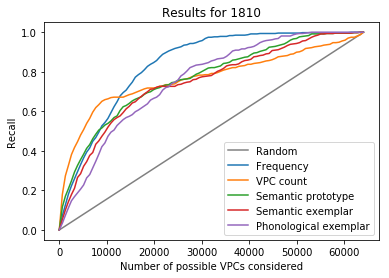

100%|██████████| 100/100 [00:00<00:00, 227.54it/s]


1810 Frequency
	Top 5-emerging: [(1, ('do', 'out')), (10, ('do', 'down')), (11, ('see', 'on')), (15, ('see', 'down')), (24, ('hear', 'up'))]
	Top 5-non emerging: [(0, ('say', 'up')), (2, ('know', 'up')), (3, ('know', 'out')), (4, ('give', 'down')), (5, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 185.49it/s]


1810 VPC count
	Top 5-emerging: [(18, ('make', 'back')), (33, ('put', 'back')), (49, ('lead', 'down')), (61, ('draw', 'over')), (66, ('leave', 'down'))]
	Top 5-non emerging: [(0, ('turn', 'behind')), (1, ('pay', 'behind')), (2, ('bring', 'behind')), (3, ('get', 'behind')), (4, ('carry', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 270.66it/s]


1810 Semantic prototype
	Top 5-emerging: [(8, ('dash', 'down')), (28, ('dash', 'up')), (31, ('hedge', 'up')), (35, ('dig', 'over')), (56, ('hang', 'off'))]
	Top 5-non emerging: [(0, ('peep', 'over')), (1, ('peep', 'up')), (2, ('peep', 'down')), (3, ('peep', 'off')), (4, ('peep', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 288.36it/s]


1810 Semantic exemplar
	Top 5-emerging: [(13, ('inquire', 'out')), (33, ('colour', 'up')), (47, ('sup', 'on')), (121, ('pan', 'out')), (142, ('shew', 'up'))]
	Top 5-non emerging: [(0, ('h', 'off')), (1, ('g', 'off')), (2, ('il', 'up')), (3, ('ce', 'up')), (4, ('u', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 218.03it/s]


1810 Phonological exemplar
	Top 5-emerging: [(18, ('stumble', 'out')), (77, ('leave', 'down')), (111, ('thrust', 'in')), (166, ('stare', 'on')), (233, ('colour', 'up'))]
	Top 5-non emerging: [(0, ('splutter', 'out')), (1, ('mediate', 'on')), (2, ('confider', 'in')), (3, ('founder', 'on')), (4, ('engraven', 'on'))]


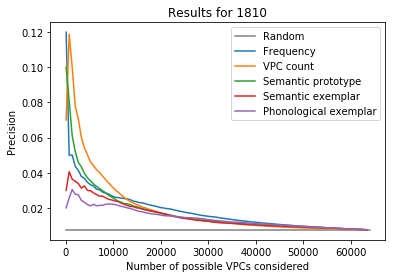

100%|██████████| 101/101 [00:00<00:00, 258.02it/s]


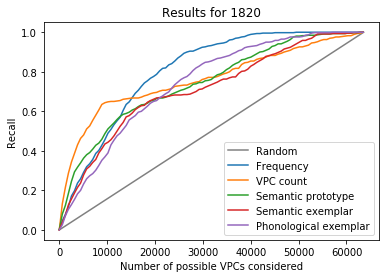

100%|██████████| 100/100 [00:00<00:00, 254.82it/s]


1820 Frequency
	Top 5-emerging: [(0, ('say', 'up')), (28, ('have', 'away')), (43, ('say', 'over')), (62, ('feel', 'up')), (115, ('find', 'over'))]
	Top 5-non emerging: [(1, ('know', 'up')), (2, ('say', 'off')), (3, ('know', 'out')), (4, ('say', 'down')), (5, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 237.34it/s]


1820 VPC count
	Top 5-emerging: [(17, ('stand', 'back')), (31, ('break', 'over')), (35, ('roll', 'back')), (53, ('cast', 'in')), (68, ('float', 'up'))]
	Top 5-non emerging: [(0, ('turn', 'behind')), (1, ('pay', 'behind')), (2, ('bring', 'behind')), (3, ('draw', 'behind')), (4, ('get', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 252.66it/s]


1820 Semantic prototype
	Top 5-emerging: [(0, ('let', 'away')), (2, ('peep', 'up')), (17, ('grind', 'up')), (48, ('pick', 'away')), (53, ('creep', 'away'))]
	Top 5-non emerging: [(1, ('jump', 'away')), (3, ('peep', 'off')), (4, ('peep', 'down')), (5, ('crack', 'down')), (6, ('crack', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 274.68it/s]


1820 Semantic exemplar
	Top 5-emerging: [(5, ('labor', 'on')), (21, ('wilt', 'away')), (207, ('rid', 'off')), (273, ('throng', 'in')), (287, ('board', 'off'))]
	Top 5-non emerging: [(0, ('tout', 'up')), (1, ('shalt', 'away')), (2, ('h', 'off')), (3, ('ou', 'up')), (4, ('quod', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 269.31it/s]


1820 Phonological exemplar
	Top 5-emerging: [(134, ('labor', 'on')), (234, ('thrust', 'on')), (306, ('lace', 'up')), (348, ('have', 'away')), (373, ('plead', 'in'))]
	Top 5-non emerging: [(0, ('splutter', 'out')), (1, ('mediate', 'on')), (2, ('confider', 'in')), (3, ('founder', 'on')), (4, ('engraven', 'on'))]


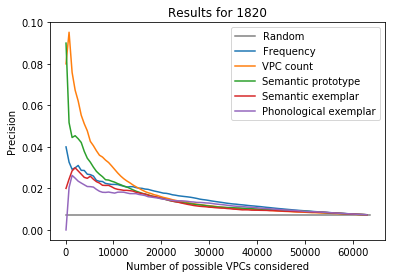

100%|██████████| 101/101 [00:00<00:00, 210.73it/s]


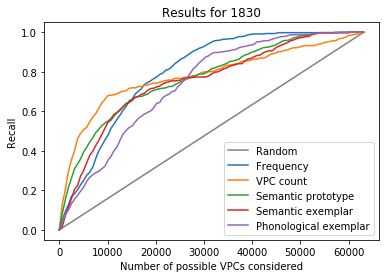

100%|██████████| 100/100 [00:00<00:00, 248.04it/s]


1830 Frequency
	Top 5-emerging: [(4, ('give', 'down')), (8, ('become', 'up')), (9, ('find', 'off')), (32, ('continue', 'out')), (60, ('consider', 'on'))]
	Top 5-non emerging: [(0, ('know', 'up')), (1, ('say', 'down')), (2, ('say', 'off')), (3, ('know', 'out')), (5, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 201.61it/s]


1830 VPC count
	Top 5-emerging: [(20, ('pull', 'over')), (30, ('come', 'back')), (36, ('lay', 'back')), (47, ('keep', 'over')), (60, ('push', 'in'))]
	Top 5-non emerging: [(0, ('turn', 'behind')), (1, ('pay', 'behind')), (2, ('bring', 'behind')), (3, ('draw', 'behind')), (4, ('get', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 238.92it/s]


1830 Semantic prototype
	Top 5-emerging: [(0, ('heave', 'out')), (9, ('crawl', 'over')), (14, ('bake', 'up')), (16, ('crawl', 'away')), (39, ('toss', 'down'))]
	Top 5-non emerging: [(1, ('stew', 'up')), (2, ('stew', 'off')), (3, ('stew', 'out')), (4, ('lick', 'down')), (5, ('stew', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 277.16it/s]


1830 Semantic exemplar
	Top 5-emerging: [(98, ('bake', 'up')), (350, ('wet', 'up')), (382, ('tin', 'over')), (404, ('hoist', 'away')), (424, ('tell', 'in'))]
	Top 5-non emerging: [(0, ('id', 'in')), (1, ('nil', 'in')), (2, ('shalt', 'away')), (3, ('shew', 'over')), (4, ('shew', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 266.97it/s]


1830 Phonological exemplar
	Top 5-emerging: [(57, ('tumble', 'on')), (87, ('stream', 'up')), (96, ('order', 'on')), (129, ('reach', 'up')), (192, ('thread', 'out'))]
	Top 5-non emerging: [(0, ('splutter', 'out')), (1, ('mediate', 'on')), (2, ('confider', 'in')), (3, ('pretreat', 'over')), (4, ('founder', 'on'))]


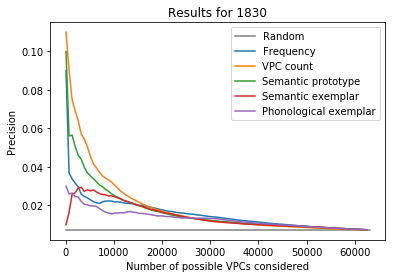

100%|██████████| 101/101 [00:00<00:00, 245.88it/s]


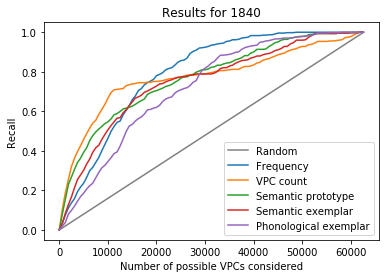

100%|██████████| 100/100 [00:00<00:00, 317.90it/s]


1840 Frequency
	Top 5-emerging: [(0, ('know', 'up')), (13, ('tell', 'up')), (55, ('lose', 'out')), (79, ('wish', 'out')), (87, ('see', 'in'))]
	Top 5-non emerging: [(1, ('know', 'out')), (2, ('say', 'off')), (3, ('say', 'down')), (4, ('appear', 'up')), (5, ('appear', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 270.47it/s]


1840 VPC count
	Top 5-emerging: [(36, ('be', 'back')), (39, ('look', 'back')), (66, ('lie', 'away')), (68, ('do', 'back')), (73, ('force', 'back'))]
	Top 5-non emerging: [(0, ('go', 'behind')), (1, ('turn', 'behind')), (2, ('drag', 'behind')), (3, ('pay', 'behind')), (4, ('pull', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 252.59it/s]


1840 Semantic prototype
	Top 5-emerging: [(22, ('toss', 'out')), (30, ('crack', 'up')), (38, ('paddle', 'up')), (44, ('creep', 'down')), (49, ('do', 'back'))]
	Top 5-non emerging: [(0, ('jump', 'away')), (1, ('intend', 'in')), (2, ('curl', 'down')), (3, ('fawn', 'up')), (4, ('curl', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 289.47it/s]


1840 Semantic exemplar
	Top 5-emerging: [(59, ('sell', 'over')), (131, ('finger', 'over')), (138, ('haste', 'away')), (200, ('curve', 'down')), (254, ('jerk', 'out'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('listeth', 'down')), (2, ('labor', 'up')), (3, ('shalt', 'away')), (4, ('h', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 236.27it/s]


1840 Phonological exemplar
	Top 5-emerging: [(76, ('bound', 'in')), (123, ('haste', 'away')), (409, ('morn', 'over')), (429, ('tick', 'on')), (490, ('side', 'out'))]
	Top 5-non emerging: [(0, ('splutter', 'out')), (1, ('mediate', 'on')), (2, ('confider', 'in')), (3, ('pretreat', 'over')), (4, ('founder', 'on'))]


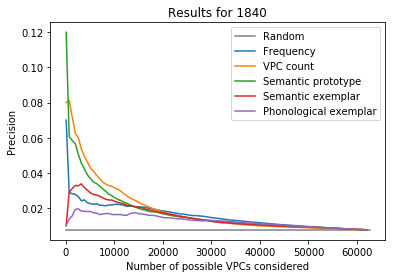

100%|██████████| 101/101 [00:00<00:00, 266.55it/s]


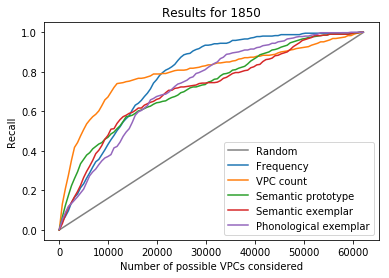

100%|██████████| 100/100 [00:00<00:00, 299.89it/s]


1850 Frequency
	Top 5-emerging: [(10, ('know', 'off')), (44, ('prove', 'up')), (94, ('feel', 'down')), (124, ('know', 'over')), (141, ('lose', 'on'))]
	Top 5-non emerging: [(0, ('say', 'down')), (1, ('say', 'off')), (2, ('know', 'out')), (3, ('appear', 'up')), (4, ('seem', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 271.60it/s]


1850 VPC count
	Top 5-emerging: [(4, ('lie', 'behind')), (36, ('stay', 'behind')), (50, ('fight', 'up')), (64, ('slip', 'back')), (106, ('sweep', 'in'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (5, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 278.81it/s]


1850 Semantic prototype
	Top 5-emerging: [(1, ('jump', 'away')), (9, ('catch', 'away')), (16, ('catch', 'off')), (18, ('ride', 'away')), (63, ('rove', 'up'))]
	Top 5-non emerging: [(0, ('away', 'away')), (2, ('reel', 'out')), (3, ('let', 'back')), (4, ('shuttle', 'up')), (5, ('try', 'back'))]


100%|██████████| 100/100 [00:00<00:00, 237.60it/s]


1850 Semantic exemplar
	Top 5-emerging: [(26, ('glimmer', 'out')), (38, ('scheme', 'out')), (54, ('throng', 'out')), (99, ('foam', 'up')), (211, ('rap', 'out'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('labour', 'over')), (2, ('labor', 'up')), (3, ('hast', 'away')), (4, ('center', 'on'))]


100%|██████████| 100/100 [00:00<00:00, 249.93it/s]


1850 Phonological exemplar
	Top 5-emerging: [(0, ('crystalliz', 'out')), (53, ('lumber', 'on')), (55, ('stumble', 'up')), (60, ('stumble', 'down')), (84, ('resign', 'in'))]
	Top 5-non emerging: [(1, ('splutter', 'out')), (2, ('mediate', 'on')), (3, ('confider', 'in')), (4, ('pretreat', 'over')), (5, ('founder', 'on'))]


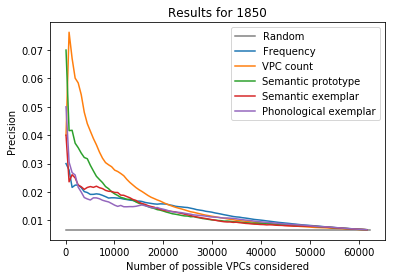

100%|██████████| 101/101 [00:00<00:00, 275.12it/s]


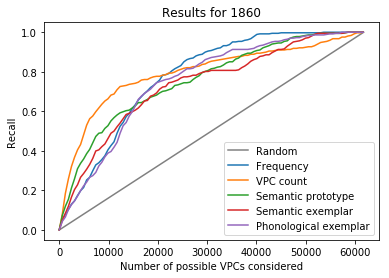

100%|██████████| 100/100 [00:00<00:00, 244.27it/s]


1860 Frequency
	Top 5-emerging: [(0, ('know', 'out')), (2, ('say', 'off')), (14, ('use', 'out')), (31, ('meet', 'out')), (54, ('rise', 'out'))]
	Top 5-non emerging: [(1, ('say', 'down')), (3, ('become', 'out')), (4, ('seem', 'up')), (5, ('appear', 'up')), (6, ('seem', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 285.01it/s]


1860 VPC count
	Top 5-emerging: [(41, ('drive', 'back')), (44, ('work', 'back')), (74, ('start', 'down')), (139, ('steal', 'over')), (145, ('conduct', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 320.25it/s]


1860 Semantic prototype
	Top 5-emerging: [(13, ('goin', 'down')), (16, ('goin', 'up')), (27, ('gie', 'up')), (35, ('steal', 'over')), (37, ('snap', 'out'))]
	Top 5-non emerging: [(0, ('goin', 'back')), (1, ('goin', 'in')), (2, ('goin', 'over')), (3, ('goin', 'away')), (4, ('goin', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 314.05it/s]


1860 Semantic exemplar
	Top 5-emerging: [(2, ('labor', 'up')), (24, ('decide', 'in')), (147, ('throng', 'up')), (195, ('goin', 'up')), (205, ('rear', 'on'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('labour', 'over')), (3, ('center', 'on')), (4, ('germinate', 'out')), (5, ('germinate', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 286.65it/s]


1860 Phonological exemplar
	Top 5-emerging: [(13, ('crumble', 'up')), (80, ('rumble', 'on')), (110, ('swerve', 'out')), (144, ('writhe', 'off')), (148, ('splash', 'out'))]
	Top 5-non emerging: [(0, ('crystallis', 'out')), (1, ('vindicate', 'in')), (2, ('splutter', 'out')), (3, ('mediate', 'on')), (4, ('confider', 'in'))]


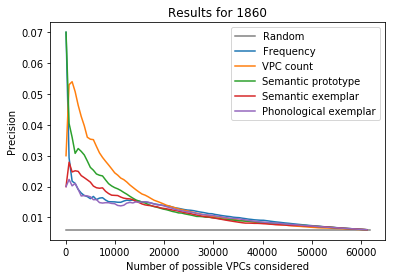

100%|██████████| 101/101 [00:00<00:00, 249.85it/s]


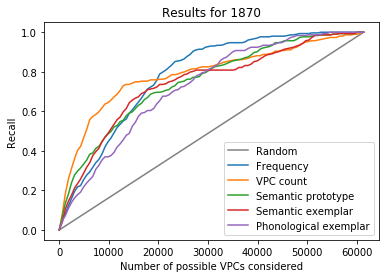

100%|██████████| 100/100 [00:00<00:00, 269.73it/s]


1870 Frequency
	Top 5-emerging: [(4, ('know', 'down')), (17, ('meet', 'up')), (25, ('contain', 'up')), (47, ('love', 'up')), (116, ('save', 'out'))]
	Top 5-non emerging: [(0, ('say', 'down')), (1, ('become', 'out')), (2, ('seem', 'up')), (3, ('seem', 'out')), (5, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 256.11it/s]


1870 VPC count
	Top 5-emerging: [(67, ('tell', 'back')), (91, ('pass', 'back')), (116, ('set', 'away')), (136, ('strike', 'away')), (204, ('sit', 'back'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 208.45it/s]


1870 Semantic prototype
	Top 5-emerging: [(56, ('rope', 'off')), (74, ('tell', 'back')), (84, ('goin', 'out')), (158, ('reel', 'out')), (206, ('shovel', 'up'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('let', 'back')), (2, ('go', 'behind')), (3, ('stick', 'off')), (4, ('wait', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 281.41it/s]


1870 Semantic exemplar
	Top 5-emerging: [(50, ('buy', 'on')), (123, ('lack', 'in')), (231, ('know', 'down')), (264, ('trot', 'over')), (377, ('battle', 'over'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('labour', 'over')), (2, ('center', 'on')), (3, ('shalt', 'away')), (4, ('hast', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 195.28it/s]


1870 Phonological exemplar
	Top 5-emerging: [(0, ('crystallis', 'out')), (45, ('rumble', 'down')), (63, ('fatten', 'out')), (64, ('stumble', 'off')), (84, ('crumble', 'on'))]
	Top 5-non emerging: [(1, ('vindicate', 'in')), (2, ('splutter', 'out')), (3, ('mediate', 'on')), (4, ('confider', 'in')), (5, ('pretreat', 'over'))]


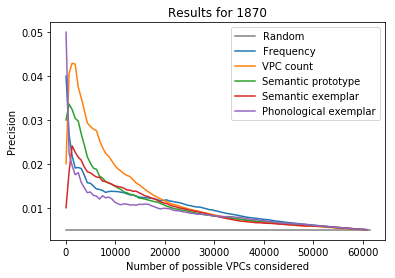

100%|██████████| 101/101 [00:00<00:00, 297.72it/s]


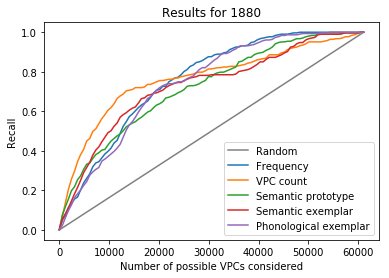

100%|██████████| 100/100 [00:00<00:00, 313.42it/s]


1880 Frequency
	Top 5-emerging: [(11, ('begin', 'up')), (29, ('seem', 'off')), (38, ('show', 'down')), (121, ('succeed', 'up')), (146, ('prove', 'on'))]
	Top 5-non emerging: [(0, ('say', 'down')), (1, ('become', 'out')), (2, ('seem', 'out')), (3, ('seem', 'up')), (4, ('appear', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 308.50it/s]


1880 VPC count
	Top 5-emerging: [(61, ('git', 'back')), (107, ('spring', 'back')), (148, ('show', 'down')), (166, ('swim', 'back')), (234, ('leap', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 165.85it/s]


1880 Semantic prototype
	Top 5-emerging: [(5, ('comin', 'out')), (16, ('leap', 'away')), (59, ('bait', 'up')), (89, ('shiver', 'off')), (100, ('thump', 'down'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('let', 'back')), (2, ('away', 'away')), (3, ('go', 'behind')), (4, ('dare', 'in'))]


100%|██████████| 100/100 [00:00<00:00, 272.77it/s]


1880 Semantic exemplar
	Top 5-emerging: [(0, ('labour', 'over')), (90, ('bloom', 'out')), (201, ('shrill', 'out')), (210, ('leap', 'away')), (255, ('scream', 'down'))]
	Top 5-non emerging: [(1, ('center', 'on')), (2, ('colour', 'down')), (3, ('hast', 'away')), (4, ('realise', 'on')), (5, ('permit', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 311.65it/s]


1880 Phonological exemplar
	Top 5-emerging: [(55, ('prattle', 'on')), (114, ('labour', 'over')), (121, ('shove', 'over')), (265, ('forge', 'on')), (284, ('leach', 'out'))]
	Top 5-non emerging: [(0, ('vindicate', 'in')), (1, ('contact', 'out')), (2, ('splutter', 'out')), (3, ('mediate', 'on')), (4, ('moulder', 'on'))]


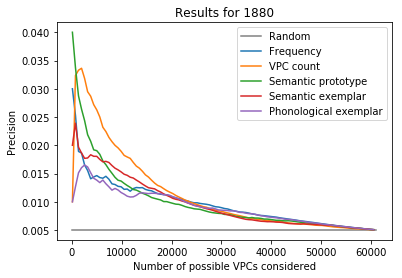

100%|██████████| 101/101 [00:00<00:00, 312.32it/s]


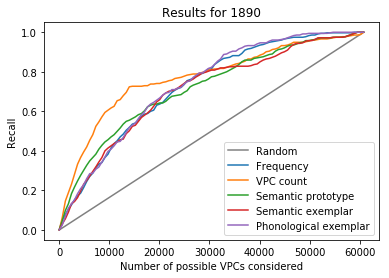

100%|██████████| 100/100 [00:00<00:00, 299.35it/s]


1890 Frequency
	Top 5-emerging: [(0, ('say', 'down')), (36, ('prove', 'out')), (44, ('allow', 'up')), (68, ('regard', 'out')), (71, ('answer', 'up'))]
	Top 5-non emerging: [(1, ('become', 'out')), (2, ('seem', 'out')), (3, ('seem', 'up')), (4, ('appear', 'out')), (5, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 249.01it/s]


1890 VPC count
	Top 5-emerging: [(51, ('shove', 'on')), (175, ('move', 'away')), (197, ('swing', 'back')), (202, ('help', 'away')), (215, ('stagger', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 252.45it/s]


1890 Semantic prototype
	Top 5-emerging: [(70, ('goad', 'up')), (140, ('lift', 'away')), (164, ('rinse', 'down')), (189, ('trot', 'down')), (242, ('kick', 'on'))]
	Top 5-non emerging: [(0, ('tonight', 'back')), (1, ('squeak', 'down')), (2, ('squeak', 'up')), (3, ('try', 'back')), (4, ('tonight', 'over'))]


100%|██████████| 100/100 [00:00<00:00, 248.99it/s]


1890 Semantic exemplar
	Top 5-emerging: [(7, ('jog', 'up')), (127, ('rinse', 'down')), (168, ('listen', 'out')), (207, ('shriek', 'up')), (245, ('trot', 'down'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('center', 'on')), (2, ('elle', 'over')), (3, ('shalt', 'away')), (4, ('tak', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 307.53it/s]


1890 Phonological exemplar
	Top 5-emerging: [(81, ('stumble', 'in')), (106, ('rumble', 'off')), (147, ('amble', 'on')), (168, ('lunge', 'up')), (178, ('lunge', 'out'))]
	Top 5-non emerging: [(0, ('vindicate', 'in')), (1, ('contact', 'out')), (2, ('splutter', 'out')), (3, ('mediate', 'on')), (4, ('moulder', 'on'))]


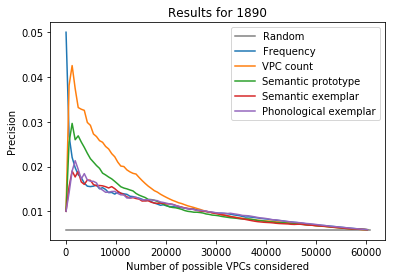

100%|██████████| 101/101 [00:00<00:00, 237.27it/s]


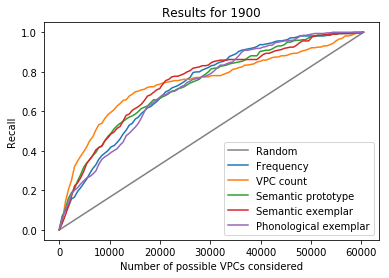

100%|██████████| 100/100 [00:00<00:00, 319.43it/s]


1900 Frequency
	Top 5-emerging: [(0, ('become', 'out')), (21, ('mean', 'up')), (46, ('speak', 'down')), (48, ('begin', 'down')), (56, ('need', 'out'))]
	Top 5-non emerging: [(1, ('seem', 'out')), (2, ('seem', 'up')), (3, ('begin', 'out')), (4, ('appear', 'out')), (5, ('become', 'on'))]


100%|██████████| 100/100 [00:00<00:00, 230.55it/s]


1900 VPC count
	Top 5-emerging: [(124, ('kick', 'back')), (130, ('sell', 'back')), (148, ('hold', 'away')), (235, ('hop', 'away')), (249, ('wear', 'back'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 277.76it/s]


1900 Semantic prototype
	Top 5-emerging: [(12, ('grab', 'off')), (16, ('gettin', 'out')), (61, ('ask', 'back')), (85, ('scuttle', 'out')), (86, ('mop', 'off'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('writhe', 'out')), (2, ('writhe', 'down')), (3, ('writhe', 'up')), (4, ('skate', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 343.35it/s]


1900 Semantic exemplar
	Top 5-emerging: [(1, ('center', 'on')), (31, ('sell', 'back')), (256, ('white', 'out')), (416, ('withdraw', 'in')), (425, ('shout', 'on'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (2, ('tellin', 'over')), (3, ('realise', 'on')), (4, ('shalt', 'away')), (5, ('ling', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 280.47it/s]


1900 Phonological exemplar
	Top 5-emerging: [(3, ('splutter', 'out')), (98, ('rumble', 'out')), (123, ('sprint', 'off')), (192, ('power', 'up')), (211, ('train', 'over'))]
	Top 5-non emerging: [(0, ('vindicate', 'in')), (1, ('develope', 'out')), (2, ('contact', 'out')), (4, ('develope', 'on')), (5, ('emigrate', 'out'))]


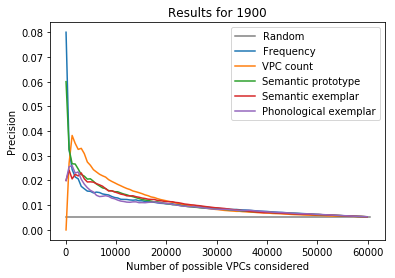

100%|██████████| 101/101 [00:00<00:00, 286.13it/s]


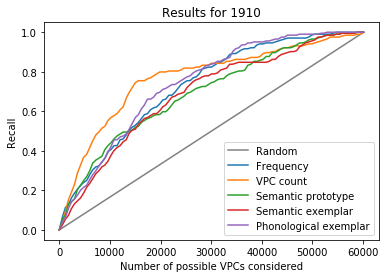

100%|██████████| 100/100 [00:00<00:00, 252.71it/s]


1910 Frequency
	Top 5-emerging: [(14, ('produce', 'out')), (54, ('provide', 'out')), (124, ('indicate', 'out')), (178, ('adopt', 'out')), (207, ('apply', 'on'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 260.65it/s]


1910 VPC count
	Top 5-emerging: [(17, ('leave', 'back')), (70, ('stagger', 'back')), (184, ('find', 'away')), (260, ('tow', 'on')), (322, ('whip', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('turn', 'behind')), (4, ('drag', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 299.41it/s]


1910 Semantic prototype
	Top 5-emerging: [(31, ('slash', 'down')), (53, ('swirl', 'up')), (132, ('leave', 'back')), (145, ('catch', 'down')), (261, ('plod', 'up'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('trudge', 'out')), (2, ('trudge', 'down')), (3, ('hev', 'out')), (4, ('spurt', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 324.80it/s]


1910 Semantic exemplar
	Top 5-emerging: [(21, ('swirl', 'up')), (149, ('et', 'up')), (223, ('grin', 'down')), (350, ('swish', 'out')), (507, ('thunder', 'off'))]
	Top 5-non emerging: [(0, ('origine', 'out')), (1, ('convex', 'down')), (2, ('convex', 'up')), (3, ('colour', 'down')), (4, ('origine', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 283.89it/s]


1910 Phonological exemplar
	Top 5-emerging: [(29, ('tinkle', 'on')), (30, ('wiggle', 'out')), (42, ('wiggle', 'up')), (149, ('praise', 'up')), (156, ('scrap', 'out'))]
	Top 5-non emerging: [(0, ('vindicate', 'in')), (1, ('develope', 'out')), (2, ('contact', 'out')), (3, ('develope', 'on')), (4, ('emigrate', 'out'))]


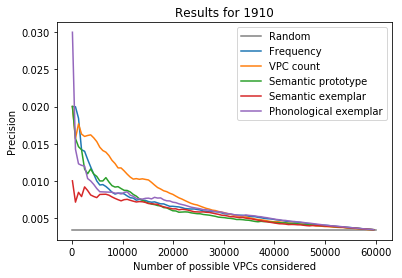

100%|██████████| 101/101 [00:00<00:00, 250.39it/s]


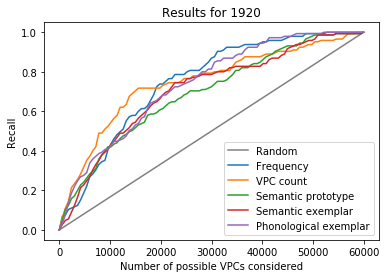

  0%|          | 0/100 [00:00<?, ?it/s]

1920 Frequency
	Top 5-emerging: [(66, ('concern', 'out')), (74, ('want', 'on')), (77, ('offer', 'out')), (168, ('require', 'off')), (169, ('spend', 'up'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('become', 'on'))]


100%|██████████| 100/100 [00:00<00:00, 257.29it/s]


1920 VPC count
	Top 5-emerging: [(81, ('talk', 'back')), (133, ('ship', 'back')), (201, ('steal', 'back')), (219, ('trace', 'back')), (236, ('wave', 'back'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 341.96it/s]


1920 Semantic prototype
	Top 5-emerging: [(153, ('steal', 'back')), (193, ('wish', 'on')), (222, ('bat', 'down')), (274, ('dive', 'over')), (339, ('bite', 'over'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('let', 'back')), (2, ('goin', 'back')), (3, ('go', 'behind')), (4, ('wait', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 334.07it/s]


1920 Semantic exemplar
	Top 5-emerging: [(76, ('mist', 'over')), (252, ('noise', 'off')), (522, ('snow', 'out')), (545, ('shear', 'out')), (666, ('want', 'on'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('realise', 'on')), (2, ('decrease', 'over')), (3, ('decrease', 'down')), (4, ('shalt', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 287.63it/s]


1920 Phonological exemplar
	Top 5-emerging: [(289, ('scurry', 'down')), (315, ('lunge', 'down')), (318, ('sprint', 'out')), (431, ('resign', 'over')), (550, ('specialise', 'in'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


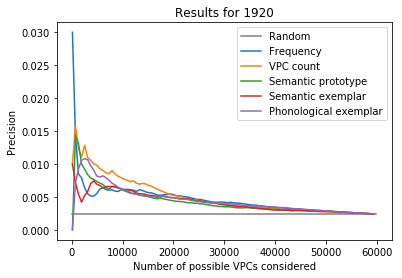

100%|██████████| 101/101 [00:00<00:00, 316.81it/s]


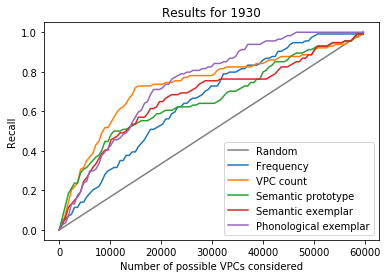

  0%|          | 0/100 [00:00<?, ?it/s]

1930 Frequency
	Top 5-emerging: [(33, ('provide', 'up')), (200, ('need', 'down')), (201, ('please', 'up')), (258, ('demand', 'up')), (276, ('attempt', 'up'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('become', 'on'))]


100%|██████████| 100/100 [00:00<00:00, 271.53it/s]


1930 VPC count
	Top 5-emerging: [(78, ('drop', 'up')), (311, ('brush', 'back')), (499, ('storm', 'in')), (664, ('squeeze', 'on')), (756, ('roar', 'over'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 229.72it/s]


1930 Semantic prototype
	Top 5-emerging: [(55, ('trigger', 'off')), (178, ('grab', 'out')), (226, ('squeeze', 'on')), (273, ('plunge', 'off')), (325, ('trap', 'out'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('let', 'back')), (2, ('go', 'behind')), (3, ('goin', 'back')), (4, ('try', 'away'))]


100%|██████████| 100/100 [00:00<00:00, 321.31it/s]


1930 Semantic exemplar
	Top 5-emerging: [(98, ('breeze', 'out')), (188, ('plow', 'on')), (386, ('skirt', 'down')), (745, ('roar', 'over')), (798, ('attempt', 'up'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('realise', 'on')), (2, ('decrease', 'over')), (3, ('decrease', 'down')), (4, ('convex', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 327.14it/s]


1930 Phonological exemplar
	Top 5-emerging: [(110, ('wiggle', 'off')), (254, ('sprint', 'on')), (364, ('slash', 'off')), (996, ('stomp', 'on')), (1214, ('spell', 'up'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


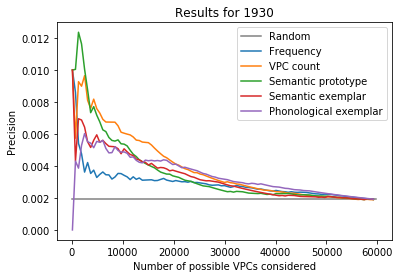

100%|██████████| 101/101 [00:00<00:00, 315.34it/s]


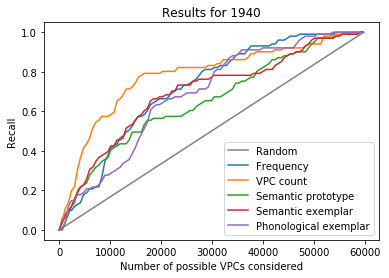

  0%|          | 0/100 [00:00<?, ?it/s]

1940 Frequency
	Top 5-emerging: [(20, ('include', 'up')), (127, ('maintain', 'up')), (202, ('develop', 'down')), (367, ('allow', 'off')), (375, ('cause', 'off'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('become', 'on'))]


100%|██████████| 100/100 [00:00<00:00, 256.03it/s]


1940 VPC count
	Top 5-emerging: [(142, ('knock', 'back')), (169, ('read', 'back')), (210, ('swing', 'away')), (276, ('suck', 'back')), (362, ('die', 'back'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 334.13it/s]


1940 Semantic prototype
	Top 5-emerging: [(637, ('wink', 'off')), (858, ('wink', 'on')), (896, ('swing', 'away')), (1111, ('whine', 'down')), (1234, ('relax', 'on'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('go', 'behind')), (2, ('let', 'back')), (3, ('wait', 'behind')), (4, ('goin', 'back'))]


100%|██████████| 100/100 [00:00<00:00, 343.99it/s]


1940 Semantic exemplar
	Top 5-emerging: [(5, ('convex', 'up')), (308, ('read', 'back')), (388, ('beef', 'up')), (454, ('beg', 'out')), (620, ('muscle', 'up'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('realise', 'on')), (2, ('decrease', 'over')), (3, ('decrease', 'down')), (4, ('convex', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 313.64it/s]


1940 Phonological exemplar
	Top 5-emerging: [(494, ('sprint', 'up')), (601, ('track', 'off')), (948, ('mash', 'out')), (1131, ('seep', 'up')), (1233, ('inch', 'down'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


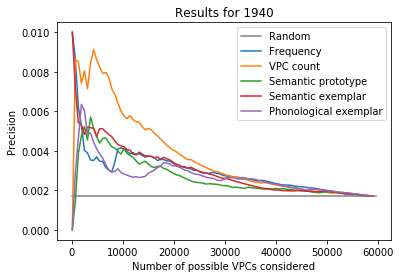

100%|██████████| 101/101 [00:00<00:00, 331.32it/s]


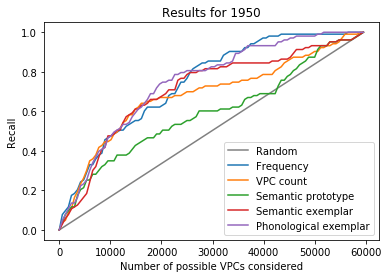

  0%|          | 0/100 [00:00<?, ?it/s]

1950 Frequency
	Top 5-emerging: [(69, ('provide', 'on')), (236, ('listen', 'up')), (269, ('limit', 'out')), (456, ('elect', 'out')), (495, ('spend', 'down'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('become', 'on')), (4, ('appear', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 291.15it/s]


1950 VPC count
	Top 5-emerging: [(193, ('play', 'back')), (335, ('sneak', 'on')), (468, ('love', 'off')), (500, ('scratch', 'down')), (1043, ('slap', 'out'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 347.32it/s]


1950 Semantic prototype
	Top 5-emerging: [(40, ('shriek', 'down')), (66, ('slap', 'out')), (199, ('scratch', 'down')), (215, ('thud', 'down')), (619, ('shovel', 'down'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('go', 'behind')), (2, ('let', 'back')), (3, ('me', 'back')), (4, ('goin', 'back'))]


100%|██████████| 100/100 [00:00<00:00, 353.38it/s]


1950 Semantic exemplar
	Top 5-emerging: [(49, ('adjust', 'out')), (367, ('shriek', 'down')), (369, ('listen', 'up')), (700, ('gross', 'up')), (982, ('sack', 'out'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('realise', 'on')), (2, ('decrease', 'over')), (3, ('decrease', 'down')), (4, ('convex', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 333.20it/s]


1950 Phonological exemplar
	Top 5-emerging: [(138, ('elect', 'out')), (235, ('angle', 'out')), (273, ('shovel', 'down')), (556, ('angle', 'down')), (581, ('capitalise', 'on'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


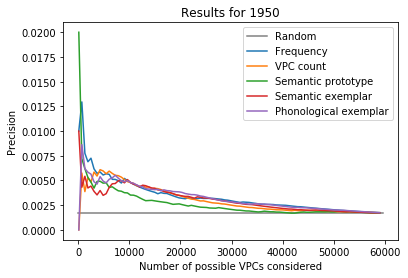

100%|██████████| 101/101 [00:00<00:00, 327.52it/s]


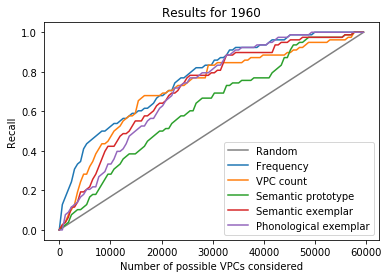

  0%|          | 0/100 [00:00<?, ?it/s]

1960 Frequency
	Top 5-emerging: [(5, ('become', 'on')), (10, ('increase', 'out')), (38, ('cause', 'out')), (83, ('refer', 'out')), (194, ('organize', 'out'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('appear', 'up'))]


100%|██████████| 100/100 [00:00<00:00, 309.53it/s]


1960 VPC count
	Top 5-emerging: [(299, ('switch', 'up')), (467, ('snap', 'away')), (1095, ('filter', 'on')), (1507, ('lure', 'over')), (1589, ('split', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 344.57it/s]


1960 Semantic prototype
	Top 5-emerging: [(39, ('kiss', 'up')), (645, ('screech', 'off')), (1353, ('snap', 'away')), (1977, ('grease', 'down')), (2080, ('toe', 'down'))]
	Top 5-non emerging: [(0, ('try', 'back')), (1, ('let', 'back')), (2, ('go', 'behind')), (3, ('away', 'away')), (4, ('down', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 372.65it/s]


1960 Semantic exemplar
	Top 5-emerging: [(156, ('oven', 'off')), (488, ('rinse', 'away')), (769, ('mob', 'up')), (1432, ('offer', 'down')), (1502, ('endure', 'on'))]
	Top 5-non emerging: [(0, ('colour', 'down')), (1, ('decrease', 'over')), (2, ('decrease', 'down')), (3, ('realise', 'on')), (4, ('centre', 'down'))]


100%|██████████| 100/100 [00:00<00:00, 332.37it/s]


1960 Phonological exemplar
	Top 5-emerging: [(633, ('spot', 'on')), (900, ('camp', 'up')), (981, ('whack', 'off')), (993, ('shit', 'out')), (1125, ('parse', 'out'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


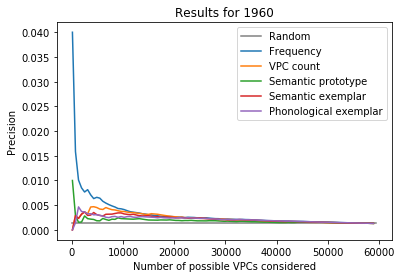

100%|██████████| 101/101 [00:00<00:00, 249.13it/s]


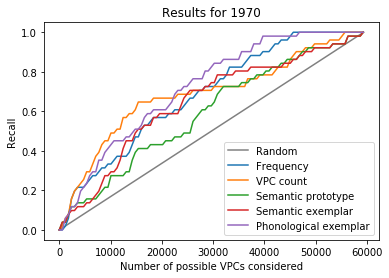

  0%|          | 0/100 [00:00<?, ?it/s]

1970 Frequency
	Top 5-emerging: [(898, ('share', 'on')), (1441, ('evaluate', 'on')), (1601, ('recognize', 'over')), (1871, ('adjust', 'down')), (1889, ('slow', 'out'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('consider', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 282.51it/s]


1970 VPC count
	Top 5-emerging: [(296, ('step', 'away')), (730, ('screw', 'over')), (1155, ('punch', 'on')), (1194, ('stomp', 'away')), (2001, ('hire', 'away'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 315.34it/s]


1970 Semantic prototype
	Top 5-emerging: [(200, ('exhale', 'down')), (364, ('gettin', 'up')), (1498, ('shit', 'off')), (1547, ('shit', 'up')), (1884, ('mist', 'up'))]
	Top 5-non emerging: [(0, ('glisten', 'out')), (1, ('dangle', 'up')), (2, ('glisten', 'up')), (3, ('glisten', 'down')), (4, ('dangle', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 317.80it/s]


1970 Semantic exemplar
	Top 5-emerging: [(245, ('gettin', 'up')), (299, ('evaluate', 'on')), (1322, ('exhale', 'down')), (1328, ('mist', 'up')), (1868, ('organise', 'out'))]
	Top 5-non emerging: [(0, ('explicate', 'away')), (1, ('denigrate', 'away')), (2, ('rethink', 'away')), (3, ('alright', 'out')), (4, ('explicate', 'over'))]


100%|██████████| 100/100 [00:00<00:00, 282.59it/s]


1970 Phonological exemplar
	Top 5-emerging: [(667, ('sulk', 'off')), (1040, ('stomp', 'away')), (1096, ('swarm', 'over')), (1338, ('shit', 'off')), (1822, ('shit', 'up'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


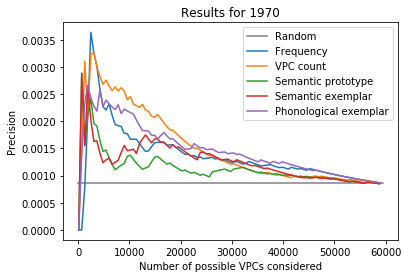

100%|██████████| 101/101 [00:00<00:00, 295.66it/s]


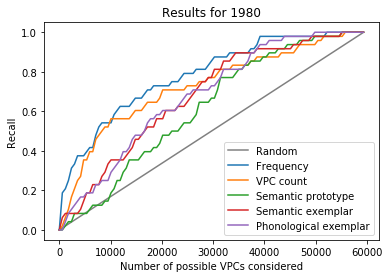

 63%|██████▎   | 63/100 [00:00<00:00, 613.15it/s]

1980 Frequency
	Top 5-emerging: [(50, ('seem', 'down')), (55, ('return', 'out')), (99, ('provide', 'off')), (222, ('limit', 'up')), (336, ('solve', 'out'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('appear', 'out')), (4, ('consider', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 230.32it/s]


1980 VPC count
	Top 5-emerging: [(328, ('stalk', 'over')), (616, ('hack', 'in')), (768, ('stomp', 'over')), (1535, ('note', 'off')), (1736, ('provide', 'off'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 333.23it/s]


1980 Semantic prototype
	Top 5-emerging: [(640, ('not', 'in')), (1342, ('grin', 'off')), (2714, ('inhale', 'down')), (2874, ('inhale', 'up')), (5843, ('align', 'on'))]
	Top 5-non emerging: [(0, ('grovel', 'out')), (1, ('wrack', 'out')), (2, ('try', 'back')), (3, ('grovel', 'up')), (4, ('prithee', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 334.24it/s]


1980 Semantic exemplar
	Top 5-emerging: [(69, ('chug', 'down')), (295, ('synchronize', 'on')), (444, ('grin', 'off')), (993, ('not', 'in')), (3567, ('seem', 'down'))]
	Top 5-non emerging: [(0, ('teeter', 'off')), (1, ('teeter', 'up')), (2, ('teeter', 'on')), (3, ('teeter', 'down')), (4, ('teeter', 'over'))]


100%|██████████| 100/100 [00:00<00:00, 202.67it/s]


1980 Phonological exemplar
	Top 5-emerging: [(1083, ('tick', 'down')), (1163, ('stalk', 'over')), (1456, ('stomp', 'over')), (1659, ('grin', 'off')), (2001, ('plead', 'out'))]
	Top 5-non emerging: [(0, ('vindicate', 'out')), (1, ('vindicate', 'in')), (2, ('develope', 'out')), (3, ('contact', 'out')), (4, ('develope', 'on'))]


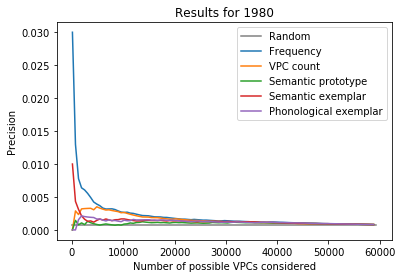

100%|██████████| 101/101 [00:00<00:00, 325.43it/s]


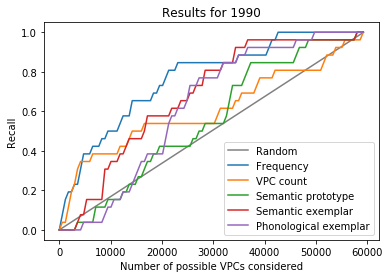

 61%|██████    | 61/100 [00:00<00:00, 594.12it/s]

1990 Frequency
	Top 5-emerging: [(180, ('select', 'up')), (192, ('create', 'on')), (636, ('exclude', 'up')), (855, ('connect', 'on')), (1233, ('offer', 'over'))]
	Top 5-non emerging: [(0, ('seem', 'out')), (1, ('seem', 'up')), (2, ('begin', 'out')), (3, ('require', 'out')), (4, ('appear', 'out'))]


100%|██████████| 100/100 [00:00<00:00, 292.78it/s]


1990 VPC count
	Top 5-emerging: [(571, ('double', 'off')), (1320, ('click', 'away')), (1524, ('click', 'in')), (2029, ('park', 'down')), (2140, ('select', 'up'))]
	Top 5-non emerging: [(0, ('look', 'behind')), (1, ('go', 'behind')), (2, ('have', 'behind')), (3, ('stagger', 'behind')), (4, ('find', 'behind'))]


100%|██████████| 100/100 [00:00<00:00, 371.28it/s]


1990 Semantic prototype
	Top 5-emerging: [(3484, ('grill', 'out')), (6576, ('click', 'in')), (6648, ('click', 'away')), (9250, ('connect', 'on')), (12298, ('debug', 'on'))]
	Top 5-non emerging: [(0, ('wrack', 'out')), (1, ('wrack', 'up')), (2, ('try', 'back')), (3, ('wrack', 'over')), (4, ('wrack', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 357.55it/s]


1990 Semantic exemplar
	Top 5-emerging: [(3274, ('stress', 'over')), (3956, ('toggle', 'on')), (4857, ('size', 'down')), (5274, ('select', 'up')), (8401, ('park', 'down'))]
	Top 5-non emerging: [(0, ('standin', 'off')), (1, ('standin', 'up')), (2, ('standin', 'on')), (3, ('standin', 'out')), (4, ('askin', 'off'))]


100%|██████████| 100/100 [00:00<00:00, 327.29it/s]


1990 Phonological exemplar
	Top 5-emerging: [(4669, ('string', 'in')), (8477, ('click', 'away')), (9024, ('grill', 'out')), (10457, ('drool', 'over')), (12367, ('partner', 'up'))]
	Top 5-non emerging: [(0, ('underlie', 'off')), (1, ('vindicate', 'out')), (2, ('vindicate', 'in')), (3, ('develope', 'out')), (4, ('contact', 'out'))]


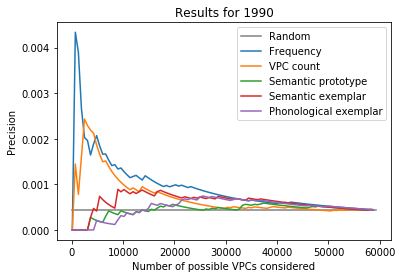

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_vpcs(novel_vpcs, ranking, ranking_name=None):
    for item in novel_vpcs:
        assert item in ranking, f"{item} not in ranking"
    n_vpcs = list(range(1, len(ranking), len(ranking) // 100))
    recall = []
    for i in tqdm(n_vpcs):
        curr_n_correct = len([item for item in ranking[:i] if item in novel_vpcs])
        recall.append(curr_n_correct / len(novel_vpcs))
    plt.plot(n_vpcs, recall, label=ranking_name)

    
def evaluate_vpcs_precision(novel_vpcs, ranking, ranking_name=None):
    for item in novel_vpcs:
        assert item in ranking, f"{item} not in ranking"
    n_vpcs = list(range(100, len(ranking), len(ranking) // 100))
    precision = []
    for i in tqdm(n_vpcs):
        curr_n_correct = len([item for item in ranking[:i] if item in novel_vpcs])
        precision.append(curr_n_correct / i)
    plt.plot(n_vpcs, precision, label=ranking_name)

    
def get_rank_list(word_to_score):
    words = list(word_to_score.keys())
    return sorted(words, key=lambda x: word_to_score[x], reverse=True)

    
def run_experiment(ranking_functions, start_decade=1810, end_decade=2000, save_figures=False):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    for year in range(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        # ROC curve
        plt.plot([0, len(POSSIBLE_VPCS) - len(known_vpcs)], [0, 1], label="Random", color="gray")
        for ranking_function in ranking_functions:
            ranking, ranking_name = ranking_function(known_vpcs, year)
            ranking = get_rank_list(ranking)
            evaluate_vpcs(novel_vpcs, ranking, ranking_name=ranking_name)    
        plt.xlabel("Number of possible VPCs considered")
        plt.ylabel("Recall")
        plt.legend()
        plt.title(f"Results for {year}")
        if save_figures:
            plt.savefig(f"ROC_curves_{year}.png", dpi=500)
        plt.show()
        
        # Precision curve
        random_precision = len(novel_vpcs) / (len(POSSIBLE_VPCS) - len(known_vpcs))
        plt.plot([0, len(POSSIBLE_VPCS) - len(known_vpcs)],
                 [random_precision, random_precision], label="Random", color="gray")
        for ranking_function in ranking_functions:
            ranking, ranking_name = ranking_function(known_vpcs, year)
            ranking = get_rank_list(ranking)
            evaluate_vpcs_precision(novel_vpcs, ranking, ranking_name=ranking_name)
            
            # Print 5 highest ranked and 5 lowest ranked VPCs that emerge this decade.
            ranking_for_emerging = [
                (i, item) for i, item in enumerate(ranking) if item in novel_vpcs]
            ranking_for_non_emerging = [
                (i, item) for i, item in enumerate(ranking) if item not in novel_vpcs]
            print(f"{year} {ranking_name}")
            print(f"\tTop 5-emerging: {ranking_for_emerging[:5]}")
            print(f"\tTop 5-non emerging: {ranking_for_non_emerging[:5]}")

        plt.xlabel("Number of possible VPCs considered")
        plt.ylabel("Precision")
        plt.legend()
        plt.title(f"Results for {year}")
        if save_figures:
            plt.savefig(f"precision_curves_{year}.png", dpi=500)
        plt.show()
                
        known_vpcs.update(novel_vpcs)


run_experiment(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking], save_figures=True)

100%|██████████| 101/101 [00:00<00:00, 186.00it/s]


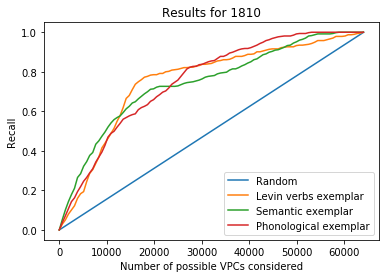

100%|██████████| 101/101 [00:00<00:00, 219.51it/s]


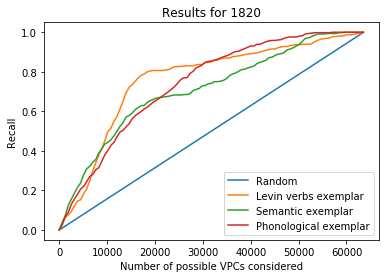

100%|██████████| 101/101 [00:00<00:00, 191.58it/s]


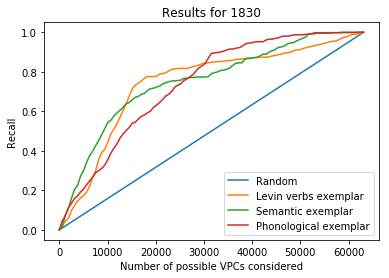

100%|██████████| 101/101 [00:00<00:00, 162.19it/s]


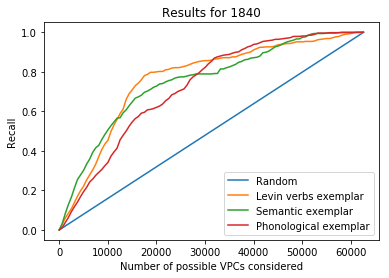

100%|██████████| 101/101 [00:00<00:00, 208.75it/s]


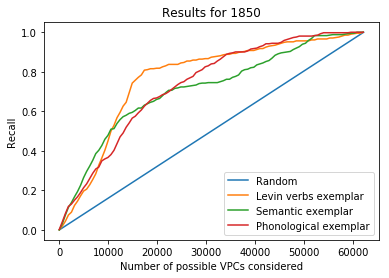

100%|██████████| 101/101 [00:00<00:00, 219.81it/s]


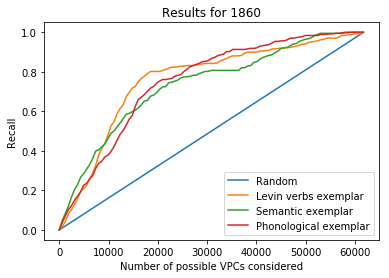

100%|██████████| 101/101 [00:00<00:00, 210.57it/s]


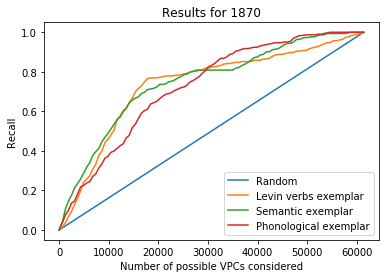

100%|██████████| 101/101 [00:00<00:00, 241.63it/s]


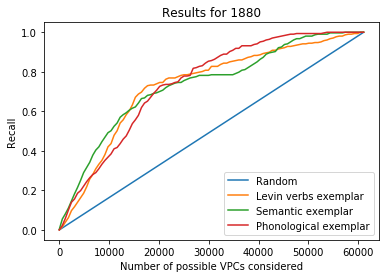

100%|██████████| 101/101 [00:00<00:00, 214.44it/s]


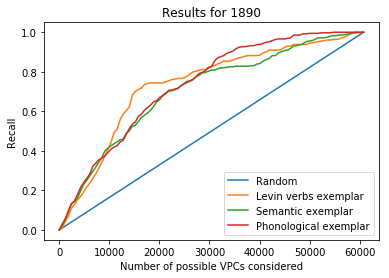

100%|██████████| 101/101 [00:00<00:00, 213.89it/s]


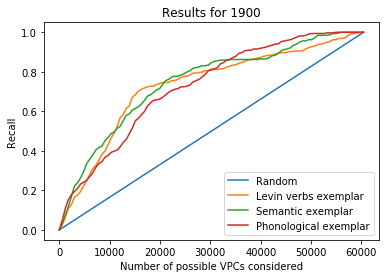

100%|██████████| 101/101 [00:00<00:00, 235.47it/s]


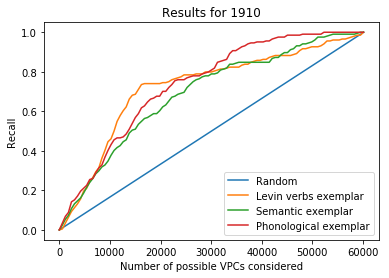

100%|██████████| 101/101 [00:00<00:00, 296.17it/s]


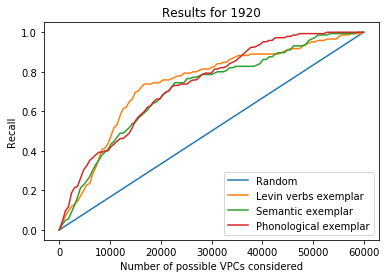

100%|██████████| 101/101 [00:00<00:00, 187.72it/s]


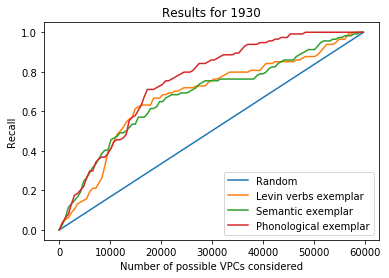

100%|██████████| 101/101 [00:00<00:00, 322.25it/s]


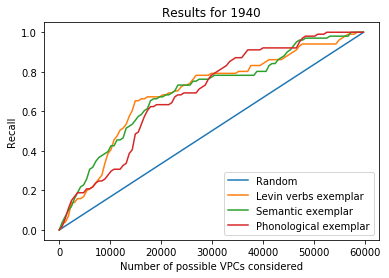

100%|██████████| 101/101 [00:00<00:00, 245.73it/s]


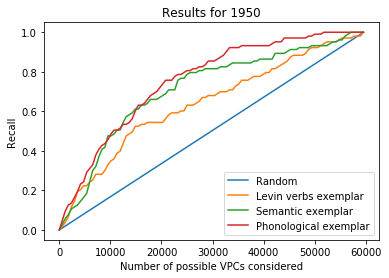

100%|██████████| 101/101 [00:00<00:00, 184.65it/s]


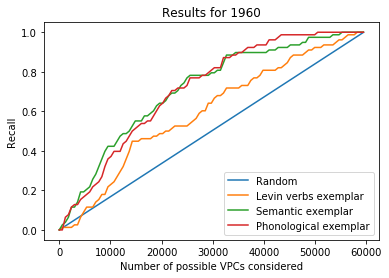

100%|██████████| 101/101 [00:00<00:00, 302.24it/s]


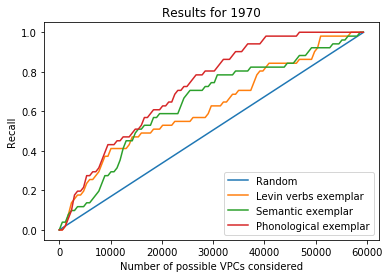

100%|██████████| 101/101 [00:00<00:00, 301.88it/s]


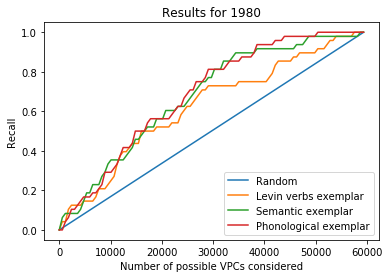

In [10]:
# TODO: In order to have a fair evaluation of the levin verbs method,
# we would need to limit the predictions of the other exemplar methods
# to only select from among levin verbs.

run_experiment(
    [get_ranking_levin_verbs,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking])

100%|██████████| 101/101 [00:00<00:00, 217.32it/s]


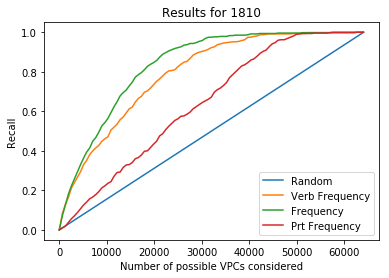

100%|██████████| 101/101 [00:00<00:00, 231.52it/s]


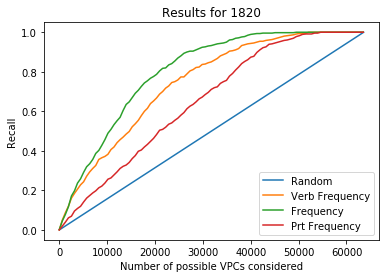

100%|██████████| 101/101 [00:00<00:00, 249.25it/s]


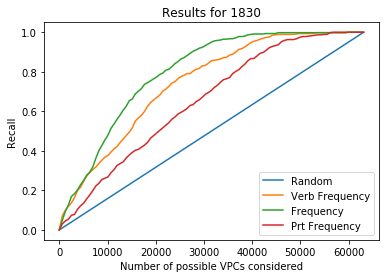

100%|██████████| 101/101 [00:00<00:00, 234.26it/s]


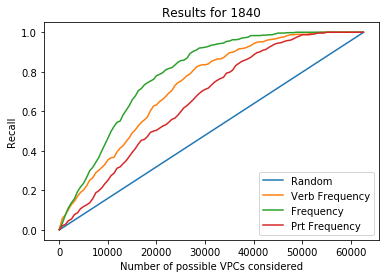

100%|██████████| 101/101 [00:00<00:00, 258.97it/s]


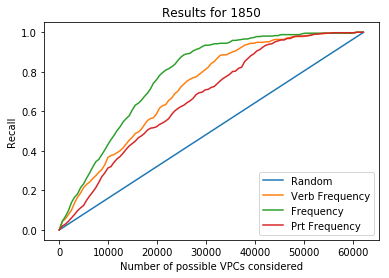

100%|██████████| 101/101 [00:00<00:00, 239.78it/s]


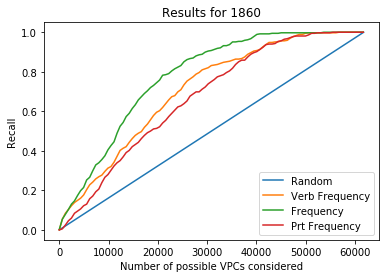

100%|██████████| 101/101 [00:00<00:00, 219.27it/s]


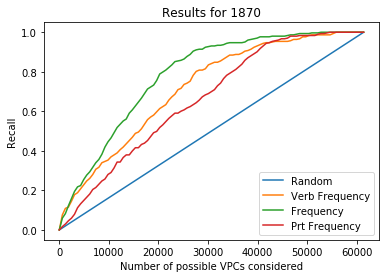

100%|██████████| 101/101 [00:00<00:00, 260.21it/s]


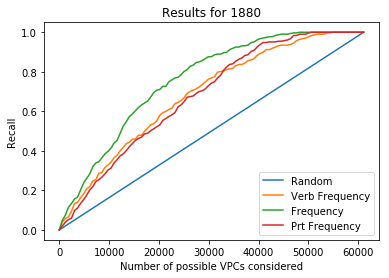

100%|██████████| 101/101 [00:00<00:00, 266.02it/s]


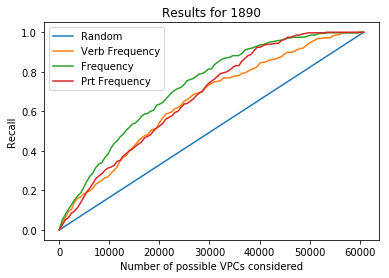

100%|██████████| 101/101 [00:00<00:00, 218.86it/s]


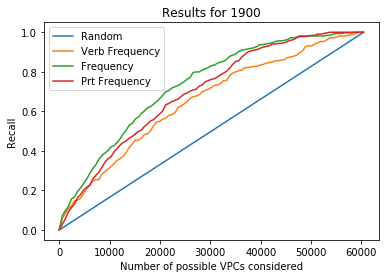

100%|██████████| 101/101 [00:00<00:00, 264.67it/s]


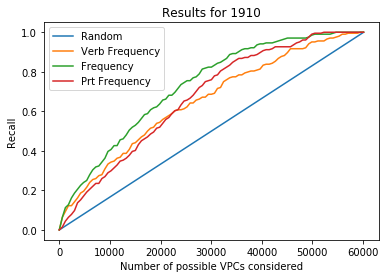

100%|██████████| 101/101 [00:00<00:00, 255.67it/s]


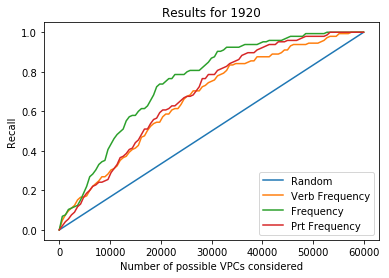

100%|██████████| 101/101 [00:00<00:00, 263.82it/s]


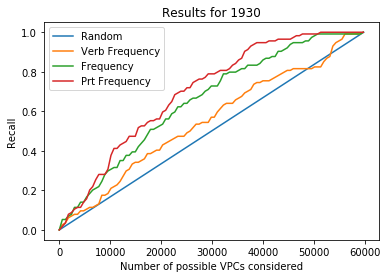

100%|██████████| 101/101 [00:00<00:00, 226.47it/s]


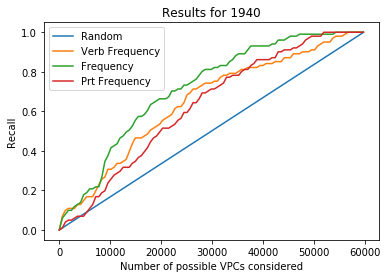

100%|██████████| 101/101 [00:00<00:00, 220.73it/s]


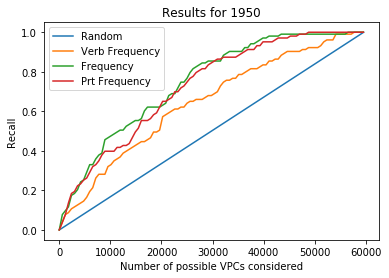

100%|██████████| 101/101 [00:00<00:00, 221.91it/s]


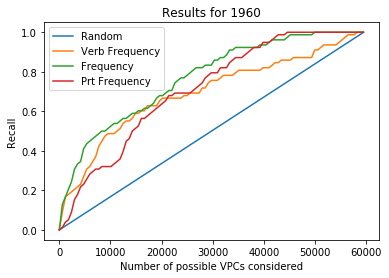

100%|██████████| 101/101 [00:00<00:00, 258.75it/s]


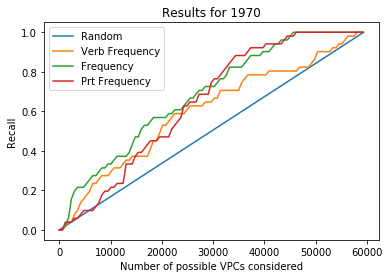

100%|██████████| 101/101 [00:00<00:00, 238.74it/s]


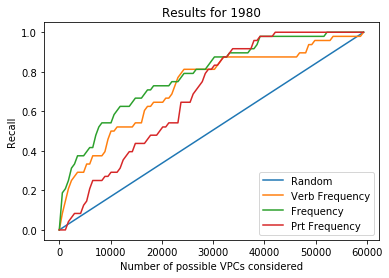

In [11]:
run_experiment(
    [get_verb_frequency_ranking,
     get_verb_particle_frequency_ranking,
     get_particle_frequency_ranking])

# Feature correlations

In [8]:
import scipy.stats
import seaborn as sns


def plot_feature_correlations(
        ranking_functions, start_decade=1810, end_decade=2000,
        plot_style="by_year"  # in {"by_year", "heatmap"}
    ):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    ranking_names = []
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[i][year] = curr_ranking
            if year == start_decade:
                ranking_names.append(ranking_name)
        known_vpcs.update(novel_vpcs)

    if plot_style == "by_year":
        feat_to_correlations = defaultdict(list)
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            feat0_scores = [func_to_rankings[0][year][curr_word] for curr_word in word_list]
            for feat_i in range(1, len(ranking_functions)):
                feati_scores = [func_to_rankings[feat_i][year][curr_word] for curr_word in word_list]
                corr = scipy.stats.pearsonr(feat0_scores, feati_scores)
                print(year, feat_i, corr)
                feat_to_correlations[feat_i].append(corr[0])

        years = list(range(start_decade, end_decade, 10))
        for feat_i, correlations in feat_to_correlations.items():
            plt.plot(years, correlations, label=ranking_names[feat_i])
        plt.ylim((0, 1))
        plt.legend()
    else:
        years = list(range(start_decade, end_decade, 10))
        feat_correlations = np.empty((len(years), len(ranking_names), len(ranking_functions)))
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            for feat1 in range(0, len(ranking_functions)):
                feat1_scores = [func_to_rankings[feat1][year][curr_word] for curr_word in word_list]

                for feat2 in range(feat1, len(ranking_functions)):
                    feat2_scores = [func_to_rankings[feat2][year][curr_word] for curr_word in word_list]
                    corr = scipy.stats.pearsonr(feat1_scores, feat2_scores)
                    feat_correlations[years.index(year), feat1, feat2] = corr[0]
                    feat_correlations[years.index(year), feat2, feat1] = corr[0]
        feat_correlations = np.mean(feat_correlations, axis=0)
        print(feat_correlations)
        sns.heatmap(feat_correlations, xticklabels=ranking_names, yticklabels=ranking_names,
                    vmin=0, vmax=1, annot=True)


100%|██████████| 19/19 [00:10<00:00,  1.94it/s]


[[1.         0.13895091 0.07111727 0.12357644 0.08625652]
 [0.13895091 1.         0.22244074 0.18914627 0.0071689 ]
 [0.07111727 0.22244074 1.         0.9512704  0.12228025]
 [0.12357644 0.18914627 0.9512704  1.         0.17485937]
 [0.08625652 0.0071689  0.12228025 0.17485937 1.        ]]


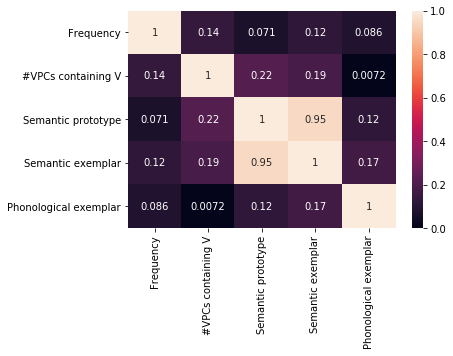

In [16]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ], plot_style="heatmap")

  5%|▌         | 1/19 [00:00<00:04,  3.93it/s]

1810 1 (0.1830621131265955, 0.0)
1810 2 (0.10017163835827633, 1.6046157605542503e-142)
1810 3 (0.14105066831387678, 6.274827030876214e-282)
1810 4 (0.09491176795819495, 4.365994715481842e-128)


 11%|█         | 2/19 [00:00<00:04,  4.14it/s]

1820 1 (0.16190104206480374, 0.0)
1820 2 (0.09375544206528663, 4.165999045982358e-124)
1820 3 (0.13437296284731967, 6.017547813772199e-254)
1820 4 (0.09025733085937662, 3.9818507848564717e-115)
1830 1 (0.16743227370929564, 0.0)


 16%|█▌        | 3/19 [00:00<00:03,  4.33it/s]

1830 2 (0.08504299956305794, 1.1790661237891998e-101)
1830 3 (0.13361149959090715, 2.8306731032142025e-249)
1830 4 (0.09169249875267872, 6.345998780594246e-118)
1840 1 (0.1561592002974837, 0.0)
1840 2 (0.08219047541828498, 2.2318714725617358e-94)


 21%|██        | 4/19 [00:00<00:03,  4.34it/s]

1840 3 (0.13426518204011526, 6.61218502462304e-250)
1840 4 (0.08992071549896596, 1.1729692467238963e-112)
1850 1 (0.15446981566625897, 0.0)
1850 2 (0.08120768820706203, 1.7238432489765175e-91)


 26%|██▋       | 5/19 [00:01<00:03,  4.38it/s]

1850 3 (0.13593234809232332, 3.1068770565898116e-254)
1850 4 (0.09095441522412008, 2.2683236577442563e-114)
1860 1 (0.14995287628471884, 1.6644178493639094e-307)
1860 2 (0.07497447041968595, 1.0119315097385638e-77)


 32%|███▏      | 6/19 [00:01<00:02,  4.45it/s]

1860 3 (0.12769365738286004, 6.972151050080045e-223)
1860 4 (0.09002763323753014, 2.363677398710663e-111)
1870 1 (0.14781496353352325, 5.3487195779820356e-297)
1870 2 (0.07882140567143943, 3.1495131027711663e-85)


 37%|███▋      | 7/19 [00:01<00:02,  4.44it/s]

1870 3 (0.13357029063668174, 2.0321364125271498e-242)
1870 4 (0.09193752772519719, 2.2016225859314767e-115)
1880 1 (0.14027551353523365, 4.364317999564911e-266)
1880 2 (0.07385564547992522, 1.1410895434485478e-74)
1880 3 (0.12947092135101224, 1.1697822057185937e-226)


 42%|████▏     | 8/19 [00:01<00:02,  4.67it/s]

1880 4 (0.08895326578740419, 1.3779044851694595e-107)
1890 1 (0.1371086951927131, 6.331061590495504e-253)
1890 2 (0.0711116442358189, 5.239847872391542e-69)
1890 3 (0.12232343880497534, 2.3222689322369963e-201)


 47%|████▋     | 9/19 [00:01<00:02,  4.67it/s]

1890 4 (0.0891043455051497, 2.047121030560582e-107)
1900 1 (0.134154127509696, 9.831093008810662e-241)
1900 2 (0.06900161266199303, 1.0574118433004052e-64)
1900 3 (0.12231760919110073, 3.5349387682789884e-200)


 53%|█████▎    | 10/19 [00:02<00:01,  4.50it/s]

1900 4 (0.0905550024538136, 2.958268361942776e-110)
1910 1 (0.13060298776718512, 5.734916146380141e-227)
1910 2 (0.06629274069978044, 1.5156860979951278e-59)
1910 3 (0.1213267506705899, 6.265532787862856e-196)


 58%|█████▊    | 11/19 [00:02<00:01,  4.42it/s]

1910 4 (0.08999165977797835, 2.4220990814520063e-108)
1920 1 (0.13139137876763676, 6.081386222357571e-229)
1920 2 (0.06588566570429899, 1.2087789521167808e-58)
1920 3 (0.12310935993637126, 4.922726773200221e-201)


 63%|██████▎   | 12/19 [00:02<00:01,  4.49it/s]

1920 4 (0.0861049350717882, 5.4991148749399305e-99)
1930 1 (0.13004899517781113, 9.3825962419013e-224)
1930 2 (0.06426751341055066, 9.465600499448147e-56)


 68%|██████▊   | 13/19 [00:02<00:01,  4.24it/s]

1930 3 (0.1230624157065286, 2.1187387230824232e-200)
1930 4 (0.08576396890328782, 5.5363695357958594e-98)
1940 1 (0.12884929919200083, 3.103691844886209e-219)
1940 2 (0.06568986510916125, 4.618246677328484e-58)


 74%|███████▎  | 14/19 [00:03<00:01,  4.21it/s]

1940 3 (0.12449364344254601, 1.0894296169959608e-204)
1940 4 (0.0848394561731171, 9.763972259593889e-96)
1950 1 (0.1280763394152639, 2.977491614288034e-216)
1950 2 (0.06455036309274367, 4.95464772656998e-56)


 79%|███████▉  | 15/19 [00:03<00:00,  4.17it/s]

1950 3 (0.12280552039468569, 7.40843920372819e-199)
1950 4 (0.082685120854819, 7.255676656926969e-91)
1960 1 (0.12073795150939595, 6.5624708299498596e-192)
1960 2 (0.057622987686287805, 6.40984480207164e-45)
1960 3 (0.11493169416078952, 5.700527592307298e-174)


 84%|████████▍ | 16/19 [00:03<00:00,  4.06it/s]

1960 4 (0.07906162792227538, 4.481307773169365e-83)
1970 1 (0.11528299596925107, 8.378999544442811e-175)
1970 2 (0.05328831887605685, 1.3055852811622629e-38)
1970 3 (0.10279887786886968, 3.1981936440990937e-139)


 89%|████████▉ | 17/19 [00:03<00:00,  4.01it/s]

1970 4 (0.07650600703255152, 8.513436139421262e-78)
1980 1 (0.11091233666262708, 9.795315488817311e-162)
1980 2 (0.05181090851647992, 1.4644733051815005e-36)
1980 3 (0.10180370051834212, 1.8972863615713284e-136)


 95%|█████████▍| 18/19 [00:04<00:00,  3.96it/s]

1980 4 (0.07334105979049933, 1.4404377150653057e-71)
1990 1 (0.11183431108034639, 2.751491825617262e-164)
1990 2 (0.051686671644601966, 2.295516512146061e-36)
1990 3 (0.09901185947205472, 4.8987206901187036e-129)


100%|██████████| 19/19 [00:04<00:00,  4.06it/s]

1990 4 (0.07226560148013382, 1.7699477647409188e-69)


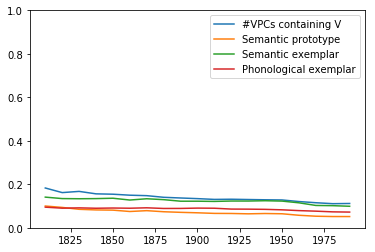

In [17]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])

# Run multiple logistic regressions, to see how the features interact

In [13]:
import numpy as np


def pickle_rankings(
        ranking_functions, output_path="func_to_rankings.pickle",
        start_decade=1810, end_decade=2000):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[ranking_name][year] = curr_ranking
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(dict(func_to_rankings), f)
    return func_to_rankings


func_to_rankings = pickle_rankings([get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])


100%|██████████| 19/19 [00:52<00:00,  2.47s/it]



  0%|          | 0/19 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.034598
         Iterations 11



  5%|▌         | 1/19 [00:01<00:34,  1.93s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64064
Model:                          Logit   Df Residuals:                    64058
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.2092
Time:                        19:06:33   Log-Likelihood:                -2216.5
converged:                       True   LL-Null:                       -2802.8
                                        LLR p-value:                2.564e-251
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.1014      0.096    -63.868      0.000      -6.289      -5.914
Frequency                 0.0560      0.015      3.788      0.000       0.027       0.085
VPC coun


 11%|█         | 2/19 [00:03<00:30,  1.79s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63589
Model:                          Logit   Df Residuals:                    63583
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1772
Time:                        19:06:35   Log-Likelihood:                -2242.6
converged:                       True   LL-Null:                       -2725.7
                                        LLR p-value:                1.362e-206
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9607      0.094    -63.324      0.000      -6.145      -5.776
Frequency                 0.0345      0.016      2.160      0.031       0.003       0.066
VPC coun


 16%|█▌        | 3/19 [00:05<00:29,  1.87s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63129
Model:                          Logit   Df Residuals:                    63123
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1957
Time:                        19:06:37   Log-Likelihood:                -2185.6
converged:                       True   LL-Null:                       -2717.4
                                        LLR p-value:                1.076e-227
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2136      0.109    -57.150      0.000      -6.427      -6.000
Frequency                 0.0415      0.017      2.443      0.015       0.008       0.075
VPC coun


 21%|██        | 4/19 [00:07<00:28,  1.91s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62670
Model:                          Logit   Df Residuals:                    62664
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1759
Time:                        19:06:39   Log-Likelihood:                -2297.1
converged:                       True   LL-Null:                       -2787.4
                                        LLR p-value:                9.529e-210
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.1266      0.108    -56.589      0.000      -6.339      -5.914
Frequency                 0.0396      0.017      2.278      0.023       0.006       0.074
VPC coun


 26%|██▋       | 5/19 [00:09<00:25,  1.85s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62196
Model:                          Logit   Df Residuals:                    62190
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1796
Time:                        19:06:41   Log-Likelihood:                -2032.7
converged:                       True   LL-Null:                       -2477.6
                                        LLR p-value:                4.026e-190
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9871      0.095    -63.277      0.000      -6.173      -5.802
Frequency                 0.0150      0.020      0.756      0.449      -0.024       0.054
VPC coun


 32%|███▏      | 6/19 [00:10<00:23,  1.77s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61784
Model:                          Logit   Df Residuals:                    61778
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1802
Time:                        19:06:42   Log-Likelihood:                -1846.4
converged:                       True   LL-Null:                       -2252.3
                                        LLR p-value:                3.354e-173
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.3299      0.119    -53.310      0.000      -6.563      -6.097
Frequency                 0.0610      0.017      3.641      0.000       0.028       0.094
VPC coun


 37%|███▋      | 7/19 [00:12<00:22,  1.88s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61416
Model:                          Logit   Df Residuals:                    61410
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1620
Time:                        19:06:44   Log-Likelihood:                -1601.9
converged:                       True   LL-Null:                       -1911.7
                                        LLR p-value:                1.232e-131
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.3777      0.124    -51.398      0.000      -6.621      -6.135
Frequency                 0.0426      0.020      2.118      0.034       0.003       0.082
VPC coun


 42%|████▏     | 8/19 [00:14<00:19,  1.78s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61113
Model:                          Logit   Df Residuals:                    61107
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1424
Time:                        19:06:46   Log-Likelihood:                -1656.3
converged:                       True   LL-Null:                       -1931.4
                                        LLR p-value:                1.218e-116
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2761      0.117    -53.534      0.000      -6.506      -6.046
Frequency                 0.0333      0.020      1.643      0.100      -0.006       0.073
VPC coun


 47%|████▋     | 9/19 [00:16<00:17,  1.72s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60806
Model:                          Logit   Df Residuals:                    60800
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1375
Time:                        19:06:48   Log-Likelihood:                -1880.0
converged:                       True   LL-Null:                       -2179.8
                                        LLR p-value:                2.401e-127
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.9557      0.094    -63.242      0.000      -6.140      -5.771
Frequency                 0.0526      0.018      2.891      0.004       0.017       0.088
VPC coun


 53%|█████▎    | 10/19 [00:18<00:16,  1.82s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60451
Model:                          Logit   Df Residuals:                    60445
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1424
Time:                        19:06:50   Log-Likelihood:                -1707.5
converged:                       True   LL-Null:                       -1991.1
                                        LLR p-value:                2.531e-120
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.2612      0.122    -51.318      0.000      -6.500      -6.022
Frequency                 0.0752      0.016      4.623      0.000       0.043       0.107
VPC coun


 58%|█████▊    | 11/19 [00:19<00:14,  1.82s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60132
Model:                          Logit   Df Residuals:                    60126
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1177
Time:                        19:06:51   Log-Likelihood:                -1203.1
converged:                       True   LL-Null:                       -1363.6
                                        LLR p-value:                 2.938e-67
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.4684      0.122    -53.189      0.000      -6.707      -6.230
Frequency                 0.0705      0.021      3.376      0.001       0.030       0.111
VPC coun


 63%|██████▎   | 12/19 [00:21<00:12,  1.86s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59928
Model:                          Logit   Df Residuals:                    59922
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.1151
Time:                        19:06:53   Log-Likelihood:                -901.07
converged:                       True   LL-Null:                       -1018.3
                                        LLR p-value:                 1.154e-48
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.8883      0.154    -44.617      0.000      -7.191      -6.586
Frequency                 0.0580      0.026      2.195      0.028       0.006       0.110
VPC coun


 68%|██████▊   | 13/19 [00:23<00:10,  1.78s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59783
Model:                          Logit   Df Residuals:                    59777
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09879
Time:                        19:06:55   Log-Likelihood:                -746.02
converged:                       True   LL-Null:                       -827.79
                                        LLR p-value:                 1.732e-33
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.9632      0.151    -46.014      0.000      -7.260      -6.667
Frequency                 0.0479      0.035      1.380      0.168      -0.020       0.116
VPC coun


 74%|███████▎  | 14/19 [00:25<00:09,  1.81s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59669
Model:                          Logit   Df Residuals:                    59663
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09820
Time:                        19:06:57   Log-Likelihood:                -672.24
converged:                       True   LL-Null:                       -745.44
                                        LLR p-value:                 7.786e-30
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.0225      0.156    -45.090      0.000      -7.328      -6.717
Frequency                 0.0394      0.035      1.122      0.262      -0.029       0.108
VPC coun


 79%|███████▉  | 15/19 [00:27<00:07,  1.77s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59568
Model:                          Logit   Df Residuals:                    59562
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.09345
Time:                        19:06:59   Log-Likelihood:                -687.17
converged:                       True   LL-Null:                       -758.01
                                        LLR p-value:                 7.914e-29
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.1280      0.168    -42.540      0.000      -7.456      -6.800
Frequency                 0.0357      0.036      1.006      0.314      -0.034       0.105
VPC coun


 84%|████████▍ | 16/19 [00:28<00:05,  1.76s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59465
Model:                          Logit   Df Residuals:                    59459
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.08963
Time:                        19:07:00   Log-Likelihood:                -542.21
converged:                       True   LL-Null:                       -595.59
                                        LLR p-value:                 1.974e-21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.3053      0.191    -38.290      0.000      -7.679      -6.931
Frequency                 0.1090      0.022      5.043      0.000       0.067       0.151
VPC coun


 89%|████████▉ | 17/19 [00:30<00:03,  1.73s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59387
Model:                          Logit   Df Residuals:                    59381
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.06644
Time:                        19:07:02   Log-Likelihood:                -383.73
converged:                       True   LL-Null:                       -411.04
                                        LLR p-value:                 1.566e-10
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.6270      0.213    -35.790      0.000      -8.045      -7.209
Frequency                -0.0569      0.127     -0.448      0.654      -0.306       0.192
VPC coun


 95%|█████████▍| 18/19 [00:31<00:01,  1.68s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59336
Model:                          Logit   Df Residuals:                    59330
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.08431
Time:                        19:07:03   Log-Likelihood:                -356.87
converged:                       True   LL-Null:                       -389.73
                                        LLR p-value:                 7.963e-13
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.7356      0.232    -33.279      0.000      -8.191      -7.280
Frequency                 0.1050      0.027      3.865      0.000       0.052       0.158
VPC coun


100%|██████████| 19/19 [00:33<00:00,  1.69s/it]


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59288
Model:                          Logit   Df Residuals:                    59282
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                 0.05855
Time:                        19:07:05   Log-Likelihood:                -213.74
converged:                       True   LL-Null:                       -227.03
                                        LLR p-value:                 6.868e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.1852      0.275    -29.781      0.000      -8.724      -7.646
Frequency                 0.0657      0.053      1.237      0.216      -0.038       0.170
VPC coun

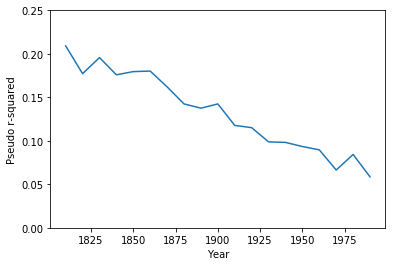

In [14]:
# Multiple regressions -- 
# Features that are consistently significant:
#   * #VPCs containing V 
#   * Nearest neighbors prototype
#   * phonological exemplar
# Features that often come out as non-significant: 
#   * VPCs containing V and 
#   * Nearest neighbors exemplar

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1810
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
feat_to_coeff = defaultdict(list)
feat_to_pval = defaultdict(list)
pseudo_r_squared = []
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
    X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]
         for curr_func in func_to_rankings})
    for feat in func_to_rankings:
        X[feat] = (X[feat] - np.mean(X[feat])) / np.std(X[feat])
        
    X = statsmodels.tools.tools.add_constant(X)
    logit = sm.Logit(y, X)
    result = logit.fit()
    print(result.summary())
    pseudo_r_squared.append(result.prsquared)
    for feat in func_to_rankings:
        feat_to_pval[feat].append(result.pvalues[feat])
        feat_to_coeff[feat].append(result.params[feat])
    known_vpcs.update(novel_vpcs)
    
plt.plot(list(range(start_decade, end_decade, 10)), pseudo_r_squared)
plt.ylim((0, 0.25))
plt.xlabel("Year")
plt.ylabel("Pseudo r-squared")
plt.savefig("pseudo_r_squared.png", dpi=500)

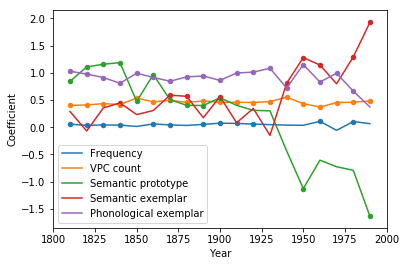

In [15]:
years = list(range(start_decade, end_decade, 10))

feat_to_color={
    "Frequency": "C0",
    "VPC count": "C1",
    "Semantic prototype": "C2",
    "Semantic exemplar": "C3",
    "Phonological exemplar": "C4"
}

for feat, coeffs in feat_to_coeff.items():
    plt.plot(years, coeffs, label=feat, color=feat_to_color[feat])
    for curr_coeff, curr_pval, curr_year in zip(coeffs, feat_to_pval[feat], years):
        if curr_pval < 0.05:
            plt.scatter([curr_year], [curr_coeff], c=feat_to_color[feat], s=20)
    
plt.legend()
plt.ylabel("Coefficient")
plt.xlabel("Year")
plt.savefig("coefficients.png", dpi=500)

In [67]:
# Individual regressions

# All predictors are significant in most decades.
# The following predictors are non-significant in at least one decade:
#    * Nearest neighbors prototype: 2 decades
#    * Nearest neighbors exemplar: 2 decades
#    * Verb Frequency * Prt Frequency: 1 decade

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1810
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    for curr_func in func_to_rankings:
        y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
        X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]})
        X = statsmodels.tools.tools.add_constant(X)
        X[curr_func] = (X[curr_func] - np.mean(X[curr_func])) / np.std(X[curr_func])
        
        logit = sm.Logit(y, X)
        result = logit.fit()
        # print(result.summary())
        print(year, curr_func, result.params[curr_func])
        if result.params[curr_func] < 0:
            raise ValueError()
    known_vpcs.update(novel_vpcs)


  0%|          | 0/19 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.042965
         Iterations 9
1810 Frequency 0.15748979717483777
Optimization terminated successfully.
         Current function value: 0.039044
         Iterations 9
1810 VPC count 0.4633227329523449
Optimization terminated successfully.
         Current function value: 0.039584
         Iterations 10
1810 Semantic prototype 2.132225629967709
Optimization terminated successfully.
         Current function value: 0.040513
         Iterations 10
1810 Semantic exemplar 1.5872294186419316



  5%|▌         | 1/19 [00:02<00:39,  2.18s/it]

Optimization terminated successfully.
         Current function value: 0.040637
         Iterations 10
1810 Phonological exemplar 1.2335605693338494
Optimization terminated successfully.
         Current function value: 0.042516
         Iterations 9
1820 Frequency 0.11739879136364707
Optimization terminated successfully.
         Current function value: 0.038847
         Iterations 9
1820 VPC count 0.4622715870297556
Optimization terminated successfully.
         Current function value: 0.039542
         Iterations 11
1820 Semantic prototype 2.307925124740908
Optimization terminated successfully.
         Current function value: 0.040634
         Iterations 11
1820 Semantic exemplar 1.4751838692161046



 11%|█         | 2/19 [00:05<00:40,  2.39s/it]

Optimization terminated successfully.
         Current function value: 0.040195
         Iterations 10
1820 Phonological exemplar 1.1713472517876335
Optimization terminated successfully.
         Current function value: 0.042604
         Iterations 9
1830 Frequency 0.1272043463285456
Optimization terminated successfully.
         Current function value: 0.038592
         Iterations 9
1830 VPC count 0.4974682547779522
Optimization terminated successfully.
         Current function value: 0.038789
         Iterations 11
1830 Semantic prototype 2.7301062568053633
Optimization terminated successfully.
         Current function value: 0.040105
         Iterations 11
1830 Semantic exemplar 1.9553146578055585



 16%|█▌        | 3/19 [00:07<00:37,  2.37s/it]

Optimization terminated successfully.
         Current function value: 0.040440
         Iterations 10
1830 Phonological exemplar 1.1739384688112338
Optimization terminated successfully.
         Current function value: 0.044155
         Iterations 9
1840 Frequency 0.11257793594658025
Optimization terminated successfully.
         Current function value: 0.040410
         Iterations 9
1840 VPC count 0.4966774747835722
Optimization terminated successfully.
         Current function value: 0.040262
         Iterations 11
1840 Semantic prototype 2.739705671580522
Optimization terminated successfully.
         Current function value: 0.041534
         Iterations 11
1840 Semantic exemplar 1.9434975086839523



 21%|██        | 4/19 [00:09<00:34,  2.30s/it]

Optimization terminated successfully.
         Current function value: 0.042154
         Iterations 10
1840 Phonological exemplar 1.0861943047131584
Optimization terminated successfully.
         Current function value: 0.039620
         Iterations 9
1850 Frequency 0.10273699069974543
Optimization terminated successfully.
         Current function value: 0.035522
         Iterations 9
1850 VPC count 0.5447679814219636
Optimization terminated successfully.
         Current function value: 0.037433
         Iterations 11
1850 Semantic prototype 2.0248411371508106
Optimization terminated successfully.
         Current function value: 0.038075
         Iterations 11
1850 Semantic exemplar 1.3944832995894167



 26%|██▋       | 5/19 [00:11<00:31,  2.23s/it]

Optimization terminated successfully.
         Current function value: 0.037513
         Iterations 10
1850 Phonological exemplar 1.199782574528597
Optimization terminated successfully.
         Current function value: 0.036029
         Iterations 9
1860 Frequency 0.1324815053634831
Optimization terminated successfully.
         Current function value: 0.033043
         Iterations 9
1860 VPC count 0.5325789045540441
Optimization terminated successfully.
         Current function value: 0.033539
         Iterations 11
1860 Semantic prototype 2.3709811088939463
Optimization terminated successfully.
         Current function value: 0.034386
         Iterations 11
1860 Semantic exemplar 1.8281904294240063



 32%|███▏      | 6/19 [00:14<00:29,  2.30s/it]

Optimization terminated successfully.
         Current function value: 0.034135
         Iterations 10
1860 Phonological exemplar 1.1472093286633915
Optimization terminated successfully.
         Current function value: 0.030839
         Iterations 9
1870 Frequency 0.1274939856524434
Optimization terminated successfully.
         Current function value: 0.028289
         Iterations 10
1870 VPC count 0.5424805509321434
Optimization terminated successfully.
         Current function value: 0.029101
         Iterations 11
1870 Semantic prototype 2.2235860902882596
Optimization terminated successfully.
         Current function value: 0.029465
         Iterations 11
1870 Semantic exemplar 1.7894560867222644



 37%|███▋      | 7/19 [00:16<00:29,  2.48s/it]

Optimization terminated successfully.
         Current function value: 0.029469
         Iterations 10
1870 Phonological exemplar 1.057488196167391
Optimization terminated successfully.
         Current function value: 0.031402
         Iterations 9
1880 Frequency 0.10878041128457229
Optimization terminated successfully.
         Current function value: 0.029417
         Iterations 10
1880 VPC count 0.5033821842766929
Optimization terminated successfully.
         Current function value: 0.029832
         Iterations 11
1880 Semantic prototype 1.95274890429086
Optimization terminated successfully.
         Current function value: 0.030049
         Iterations 11
1880 Semantic exemplar 1.655037046938009



 42%|████▏     | 8/19 [00:19<00:27,  2.51s/it]

Optimization terminated successfully.
         Current function value: 0.029738
         Iterations 10
1880 Phonological exemplar 1.1350900006024718
Optimization terminated successfully.
         Current function value: 0.035547
         Iterations 9
1890 Frequency 0.11998087342241534
Optimization terminated successfully.
         Current function value: 0.033314
         Iterations 9
1890 VPC count 0.5123651681055291
Optimization terminated successfully.
         Current function value: 0.034326
         Iterations 11
1890 Semantic prototype 1.4690573021079527
Optimization terminated successfully.
         Current function value: 0.034622
         Iterations 11
1890 Semantic exemplar 1.1870585557442725



 47%|████▋     | 9/19 [00:22<00:25,  2.57s/it]

Optimization terminated successfully.
         Current function value: 0.033771
         Iterations 10
1890 Phonological exemplar 1.1137896293636422
Optimization terminated successfully.
         Current function value: 0.032535
         Iterations 9
1900 Frequency 0.13893705007786034
Optimization terminated successfully.
         Current function value: 0.030713
         Iterations 10
1900 VPC count 0.5148891550214048
Optimization terminated successfully.
         Current function value: 0.031062
         Iterations 11
1900 Semantic prototype 1.8823294075372605
Optimization terminated successfully.
         Current function value: 0.031255
         Iterations 11
1900 Semantic exemplar 1.8187018927125365



 53%|█████▎    | 10/19 [00:24<00:23,  2.58s/it]

Optimization terminated successfully.
         Current function value: 0.031125
         Iterations 10
1900 Phonological exemplar 1.099754829792727
Optimization terminated successfully.
         Current function value: 0.022482
         Iterations 10
1910 Frequency 0.12398602450138589
Optimization terminated successfully.
         Current function value: 0.021447
         Iterations 10
1910 VPC count 0.4927452837444718
Optimization terminated successfully.
         Current function value: 0.021913
         Iterations 11
1910 Semantic prototype 1.2911150849794581
Optimization terminated successfully.
         Current function value: 0.022042
         Iterations 11
1910 Semantic exemplar 1.109378351901655



 58%|█████▊    | 11/19 [00:27<00:21,  2.71s/it]

Optimization terminated successfully.
         Current function value: 0.021396
         Iterations 11
1910 Phonological exemplar 1.176000318910546
Optimization terminated successfully.
         Current function value: 0.016881
         Iterations 10
1920 Frequency 0.11406915966894628
Optimization terminated successfully.
         Current function value: 0.016121
         Iterations 10
1920 VPC count 0.4957786595013372
Optimization terminated successfully.
         Current function value: 0.016364
         Iterations 12
1920 Semantic prototype 1.483468887020907
Optimization terminated successfully.
         Current function value: 0.016428
         Iterations 12
1920 Semantic exemplar 1.3443619898066954



 63%|██████▎   | 12/19 [00:30<00:19,  2.73s/it]

Optimization terminated successfully.
         Current function value: 0.016039
         Iterations 11
1920 Phonological exemplar 1.214071049346273
Optimization terminated successfully.
         Current function value: 0.013796
         Iterations 10
1930 Frequency 0.09631953272554891
Optimization terminated successfully.
         Current function value: 0.013228
         Iterations 11
1930 VPC count 0.4809083238591375
Optimization terminated successfully.
         Current function value: 0.013616
         Iterations 12
1930 Semantic prototype 0.7541474419681824
Optimization terminated successfully.
         Current function value: 0.013669
         Iterations 11
1930 Semantic exemplar 0.6066166493997857



 68%|██████▊   | 13/19 [00:33<00:16,  2.78s/it]

Optimization terminated successfully.
         Current function value: 0.013089
         Iterations 11
1930 Phonological exemplar 1.2254425216997389
Optimization terminated successfully.
         Current function value: 0.012427
         Iterations 10
1940 Frequency 0.10550545380198247
Optimization terminated successfully.
         Current function value: 0.011753
         Iterations 11
1940 VPC count 0.5340765089044217
Optimization terminated successfully.
         Current function value: 0.012240
         Iterations 12
1940 Semantic prototype 0.9019888475557866
Optimization terminated successfully.
         Current function value: 0.012182
         Iterations 12
1940 Semantic exemplar 1.061273233129873



 74%|███████▎  | 14/19 [00:36<00:14,  2.84s/it]

Optimization terminated successfully.
         Current function value: 0.012108
         Iterations 11
1940 Phonological exemplar 0.8661553152978316
Optimization terminated successfully.
         Current function value: 0.012653
         Iterations 10
1950 Frequency 0.1135759568824801
Optimization terminated successfully.
         Current function value: 0.012384
         Iterations 11
1950 VPC count 0.40862029197422095
Optimization terminated successfully.
         Current function value: 0.012626
         Iterations 11
1950 Semantic prototype 0.43666639829866627
Optimization terminated successfully.
         Current function value: 0.012493
         Iterations 12
1950 Semantic exemplar 0.8033551268698494



 79%|███████▉  | 15/19 [00:39<00:11,  2.83s/it]

Optimization terminated successfully.
         Current function value: 0.012020
         Iterations 12
1950 Phonological exemplar 1.2525010677514896
Optimization terminated successfully.
         Current function value: 0.009754
         Iterations 11
1960 Frequency 0.16231818243975785
Optimization terminated successfully.
         Current function value: 0.009760
         Iterations 11
1960 VPC count 0.4088233215169995
Optimization terminated successfully.
         Current function value: 0.009862
         Iterations 12
1960 Semantic prototype 0.7300416231638805
Optimization terminated successfully.
         Current function value: 0.009722
         Iterations 13
1960 Semantic exemplar 1.32351499267017



 84%|████████▍ | 16/19 [00:41<00:08,  2.71s/it]

Optimization terminated successfully.
         Current function value: 0.009641
         Iterations 12
1960 Phonological exemplar 1.0011768006408133
Optimization terminated successfully.
         Current function value: 0.006918
         Iterations 11
1970 Frequency 0.05739304807017388
Optimization terminated successfully.
         Current function value: 0.006750
         Iterations 11
1970 VPC count 0.413000076111622
Optimization terminated successfully.
         Current function value: 0.006883
         Iterations 12
1970 Semantic prototype 0.3640876454095964
Optimization terminated successfully.
         Current function value: 0.006867
         Iterations 12
1970 Semantic exemplar 0.4591371989175909



 89%|████████▉ | 17/19 [00:44<00:05,  2.60s/it]

Optimization terminated successfully.
         Current function value: 0.006641
         Iterations 12
1970 Phonological exemplar 1.0921575356004458
Optimization terminated successfully.
         Current function value: 0.006410
         Iterations 11
1980 Frequency 0.16166223781168598
Optimization terminated successfully.
         Current function value: 0.006359
         Iterations 11
1980 VPC count 0.45328183653920745
Optimization terminated successfully.
         Current function value: 0.006482
         Iterations 12
1980 Semantic prototype 0.6715364356833631
Optimization terminated successfully.
         Current function value: 0.006410
         Iterations 13
1980 Semantic exemplar 1.165877894557424



 95%|█████████▍| 18/19 [00:47<00:02,  2.72s/it]

Optimization terminated successfully.
         Current function value: 0.006394
         Iterations 12
1980 Phonological exemplar 0.8434555160708257
Optimization terminated successfully.
         Current function value: 0.003792
         Iterations 12
1990 Frequency 0.14030986489958364
Optimization terminated successfully.
         Current function value: 0.003746
         Iterations 12
1990 VPC count 0.4076581100519544
Optimization terminated successfully.
         Current function value: 0.003809
         Iterations 12
1990 Semantic prototype 0.3733368060222699
Optimization terminated successfully.
         Current function value: 0.003769
         Iterations 13
1990 Semantic exemplar 0.8463933076808763



100%|██████████| 19/19 [00:49<00:00,  2.65s/it]


Optimization terminated successfully.
         Current function value: 0.003787
         Iterations 12
1990 Phonological exemplar 0.5252403019796272
